## Question 1

In [70]:
run_times = {}

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import matplotlib.pyplot as plt
import time

MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Build model
tf.keras.backend.set_floatx('float32')

In [72]:
class CharCNN(Model):
    def __init__(self, vocab_size=256):
        super(CharCNN, self).__init__()
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        # forward
        x = tf.one_hot(x, one_hot_size)
        x = x[..., tf.newaxis] 
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

model = CharCNN(256)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

start = time.time()
for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
end = time.time()
print("Time elapsed in seconds: " + str(end - start))
run_times['CNN_char_Adam'] = end - start

Epoch 1, Loss: 2.1793553829193115, Accuracy: 0.2544642984867096, Test Loss: 1.6053433418273926, Test Accuracy: 0.46857142448425293
Epoch 2, Loss: 1.2516388893127441, Accuracy: 0.5846428275108337, Test Loss: 1.2202842235565186, Test Accuracy: 0.6100000143051147
Epoch 3, Loss: 0.9276861548423767, Accuracy: 0.6976785659790039, Test Loss: 1.1537984609603882, Test Accuracy: 0.6414285898208618
Epoch 4, Loss: 0.6967939138412476, Accuracy: 0.7639285922050476, Test Loss: 1.182706356048584, Test Accuracy: 0.645714282989502
Epoch 5, Loss: 0.5515121221542358, Accuracy: 0.8137500286102295, Test Loss: 1.1466209888458252, Test Accuracy: 0.6814285516738892
Epoch 6, Loss: 0.43615639209747314, Accuracy: 0.8519642949104309, Test Loss: 1.2663302421569824, Test Accuracy: 0.6671428680419922
Epoch 7, Loss: 0.34155353903770447, Accuracy: 0.8899999856948853, Test Loss: 1.375961422920227, Test Accuracy: 0.6742857098579407
Epoch 8, Loss: 0.29531580209732056, Accuracy: 0.9053571224212646, Test Loss: 1.42647981643

Epoch 64, Loss: 0.0006998276803642511, Accuracy: 1.0, Test Loss: 3.400053024291992, Test Accuracy: 0.6814285516738892
Epoch 65, Loss: 0.0006881856825202703, Accuracy: 1.0, Test Loss: 3.400611162185669, Test Accuracy: 0.677142858505249
Epoch 66, Loss: 0.0006028204807080328, Accuracy: 1.0, Test Loss: 3.4028751850128174, Test Accuracy: 0.6800000071525574
Epoch 67, Loss: 0.0005420353845693171, Accuracy: 1.0, Test Loss: 3.4145591259002686, Test Accuracy: 0.6785714030265808
Epoch 68, Loss: 0.0005310885026119649, Accuracy: 1.0, Test Loss: 3.416388511657715, Test Accuracy: 0.6800000071525574
Epoch 69, Loss: 0.0004827342927455902, Accuracy: 1.0, Test Loss: 3.4170379638671875, Test Accuracy: 0.677142858505249
Epoch 70, Loss: 0.0004392458940856159, Accuracy: 1.0, Test Loss: 3.4297497272491455, Test Accuracy: 0.6800000071525574
Epoch 71, Loss: 0.00043304311111569405, Accuracy: 1.0, Test Loss: 3.427579164505005, Test Accuracy: 0.6742857098579407
Epoch 72, Loss: 0.0004872734425589442, Accuracy: 1.0,

Epoch 133, Loss: 4.51028608949855e-05, Accuracy: 1.0, Test Loss: 3.603590726852417, Test Accuracy: 0.6728571653366089
Epoch 134, Loss: 4.4542935938807204e-05, Accuracy: 1.0, Test Loss: 3.6019821166992188, Test Accuracy: 0.677142858505249
Epoch 135, Loss: 4.248942423146218e-05, Accuracy: 1.0, Test Loss: 3.605698585510254, Test Accuracy: 0.6728571653366089
Epoch 136, Loss: 4.18650233768858e-05, Accuracy: 1.0, Test Loss: 3.6084985733032227, Test Accuracy: 0.6742857098579407
Epoch 137, Loss: 3.983831993537024e-05, Accuracy: 1.0, Test Loss: 3.609990119934082, Test Accuracy: 0.6742857098579407
Epoch 138, Loss: 3.895816917065531e-05, Accuracy: 1.0, Test Loss: 3.6127567291259766, Test Accuracy: 0.6742857098579407
Epoch 139, Loss: 3.813297371380031e-05, Accuracy: 1.0, Test Loss: 3.6129868030548096, Test Accuracy: 0.6714285612106323
Epoch 140, Loss: 3.747561640921049e-05, Accuracy: 1.0, Test Loss: 3.615460157394409, Test Accuracy: 0.6742857098579407
Epoch 141, Loss: 3.6370864108903334e-05, Accur

Epoch 202, Loss: 9.356291229778435e-06, Accuracy: 1.0, Test Loss: 3.722646713256836, Test Accuracy: 0.6757143139839172
Epoch 203, Loss: 8.997260010801256e-06, Accuracy: 1.0, Test Loss: 3.7219293117523193, Test Accuracy: 0.6757143139839172
Epoch 204, Loss: 8.934474863053765e-06, Accuracy: 1.0, Test Loss: 3.7240536212921143, Test Accuracy: 0.6757143139839172
Epoch 205, Loss: 8.5595484051737e-06, Accuracy: 1.0, Test Loss: 3.7266523838043213, Test Accuracy: 0.6757143139839172
Epoch 206, Loss: 8.434997653239407e-06, Accuracy: 1.0, Test Loss: 3.7279999256134033, Test Accuracy: 0.6757143139839172
Epoch 207, Loss: 8.229410923377145e-06, Accuracy: 1.0, Test Loss: 3.7294979095458984, Test Accuracy: 0.6757143139839172
Epoch 208, Loss: 8.112229807011317e-06, Accuracy: 1.0, Test Loss: 3.7314350605010986, Test Accuracy: 0.6757143139839172
Epoch 209, Loss: 7.968370482558385e-06, Accuracy: 1.0, Test Loss: 3.7333781719207764, Test Accuracy: 0.6742857098579407
Epoch 210, Loss: 7.848006134736352e-06, Acc

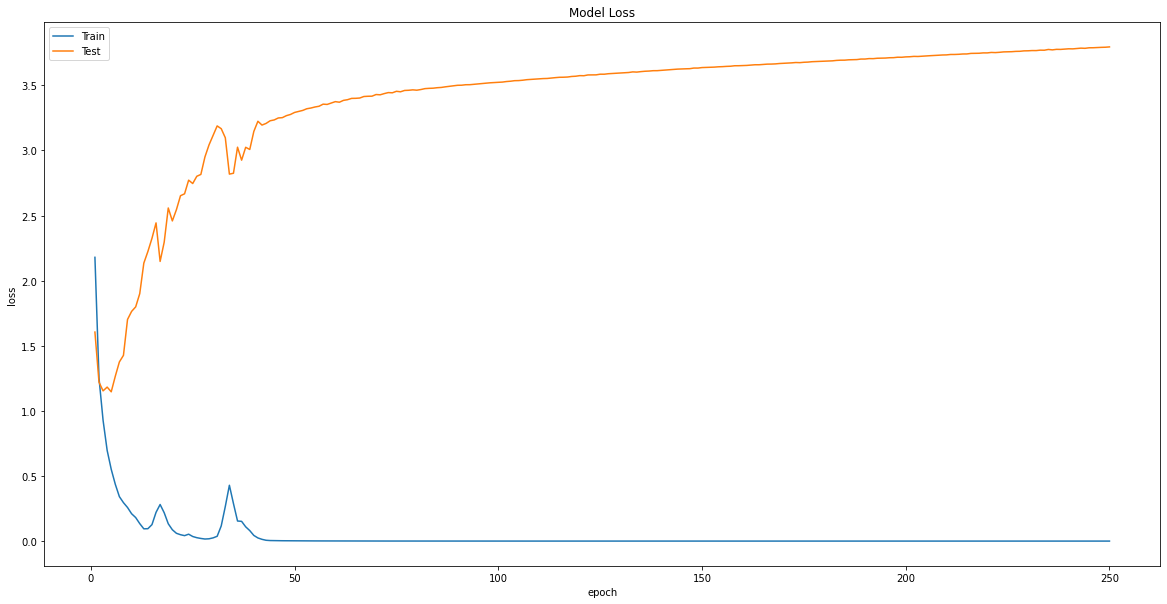

In [73]:
# Save the plot for losses
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_ls) + 1), train_ls, label='Train')
plt.plot(range(1, len(test_ls) + 1), test_ls, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_Adam_qn1_loss_no_dropout.pdf'
)

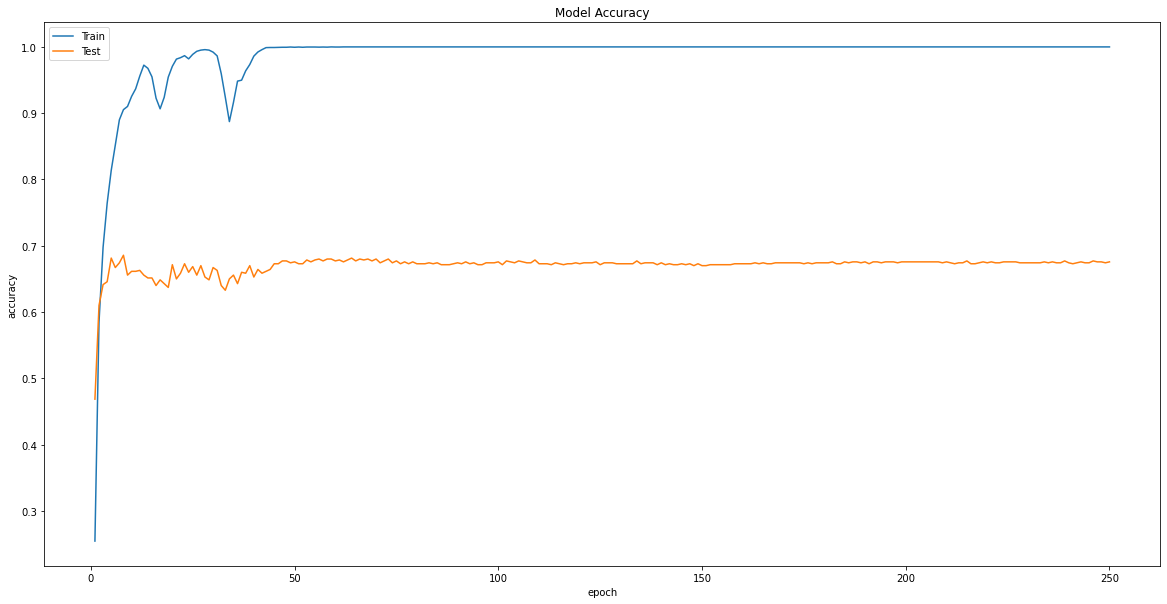

In [74]:
# Save the plot for accuracies
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_Adam_qn1_accuracy_no_dropout.pdf'
)

In [75]:
model = CharCNN(256)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

start = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
end = time.time()
print("Time elapsed in seconds: " + str(end - start))
run_times['CNN_char_SGD'] = end - start

Epoch 1, Loss: 2.7073583602905273, Accuracy: 0.07374999672174454, Test Loss: 2.703814744949341, Test Accuracy: 0.09142857044935226
Epoch 2, Loss: 2.7009999752044678, Accuracy: 0.1116071417927742, Test Loss: 2.698881149291992, Test Accuracy: 0.10428571701049805
Epoch 3, Loss: 2.6952767372131348, Accuracy: 0.13089285790920258, Test Loss: 2.6940181255340576, Test Accuracy: 0.1314285695552826
Epoch 4, Loss: 2.6896088123321533, Accuracy: 0.1435714215040207, Test Loss: 2.689058303833008, Test Accuracy: 0.14571428298950195
Epoch 5, Loss: 2.6837685108184814, Accuracy: 0.1574999988079071, Test Loss: 2.683931589126587, Test Accuracy: 0.15571428835391998
Epoch 6, Loss: 2.6778478622436523, Accuracy: 0.1817857176065445, Test Loss: 2.6783485412597656, Test Accuracy: 0.1614285707473755
Epoch 7, Loss: 2.6714887619018555, Accuracy: 0.18250000476837158, Test Loss: 2.672248601913452, Test Accuracy: 0.19142857193946838
Epoch 8, Loss: 2.6648683547973633, Accuracy: 0.1971428543329239, Test Loss: 2.666164875

Epoch 64, Loss: 1.0982893705368042, Accuracy: 0.6492857336997986, Test Loss: 1.303837776184082, Test Accuracy: 0.558571457862854
Epoch 65, Loss: 1.099076509475708, Accuracy: 0.6494643092155457, Test Loss: 1.3742424249649048, Test Accuracy: 0.5328571200370789
Epoch 66, Loss: 1.0870915651321411, Accuracy: 0.6537500023841858, Test Loss: 1.308007836341858, Test Accuracy: 0.5657142996788025
Epoch 67, Loss: 1.069082260131836, Accuracy: 0.6548214554786682, Test Loss: 1.2774776220321655, Test Accuracy: 0.581428587436676
Epoch 68, Loss: 1.0564755201339722, Accuracy: 0.6635714173316956, Test Loss: 1.270013451576233, Test Accuracy: 0.5799999833106995
Epoch 69, Loss: 1.0397664308547974, Accuracy: 0.6655356884002686, Test Loss: 1.2577393054962158, Test Accuracy: 0.5799999833106995
Epoch 70, Loss: 1.030569314956665, Accuracy: 0.6723214387893677, Test Loss: 1.2928770780563354, Test Accuracy: 0.5528571605682373
Epoch 71, Loss: 1.014400601387024, Accuracy: 0.673035740852356, Test Loss: 1.27277636528015

Epoch 127, Loss: 0.5875722169876099, Accuracy: 0.8135714530944824, Test Loss: 1.1016432046890259, Test Accuracy: 0.6471428275108337
Epoch 128, Loss: 0.6000351309776306, Accuracy: 0.8141071200370789, Test Loss: 1.1829299926757812, Test Accuracy: 0.6114285588264465
Epoch 129, Loss: 0.6022992730140686, Accuracy: 0.804107129573822, Test Loss: 1.0681415796279907, Test Accuracy: 0.6514285802841187
Epoch 130, Loss: 0.5899308323860168, Accuracy: 0.8151785731315613, Test Loss: 1.0320385694503784, Test Accuracy: 0.6671428680419922
Epoch 131, Loss: 0.608573853969574, Accuracy: 0.8076785802841187, Test Loss: 1.2235209941864014, Test Accuracy: 0.5985714197158813
Epoch 132, Loss: 0.5581305027008057, Accuracy: 0.8207142949104309, Test Loss: 1.0679402351379395, Test Accuracy: 0.645714282989502
Epoch 133, Loss: 0.5713939666748047, Accuracy: 0.8201785683631897, Test Loss: 1.1189731359481812, Test Accuracy: 0.6385714411735535
Epoch 134, Loss: 0.6032931804656982, Accuracy: 0.8057143092155457, Test Loss: 1

Epoch 190, Loss: 0.3836219906806946, Accuracy: 0.8807142972946167, Test Loss: 1.1154733896255493, Test Accuracy: 0.6728571653366089
Epoch 191, Loss: 0.3726106584072113, Accuracy: 0.8808928728103638, Test Loss: 1.2554086446762085, Test Accuracy: 0.6471428275108337
Epoch 192, Loss: 0.36305564641952515, Accuracy: 0.8858928680419922, Test Loss: 1.128408432006836, Test Accuracy: 0.654285728931427
Epoch 193, Loss: 0.35837358236312866, Accuracy: 0.8899999856948853, Test Loss: 1.2720342874526978, Test Accuracy: 0.6442857384681702
Epoch 194, Loss: 0.3764439523220062, Accuracy: 0.8810714483261108, Test Loss: 1.2558034658432007, Test Accuracy: 0.6571428775787354
Epoch 195, Loss: 0.3801470696926117, Accuracy: 0.8812500238418579, Test Loss: 1.207663655281067, Test Accuracy: 0.6700000166893005
Epoch 196, Loss: 0.3593454360961914, Accuracy: 0.8889285922050476, Test Loss: 1.1859709024429321, Test Accuracy: 0.6642857193946838
Epoch 197, Loss: 0.3373606503009796, Accuracy: 0.9003571271896362, Test Loss:

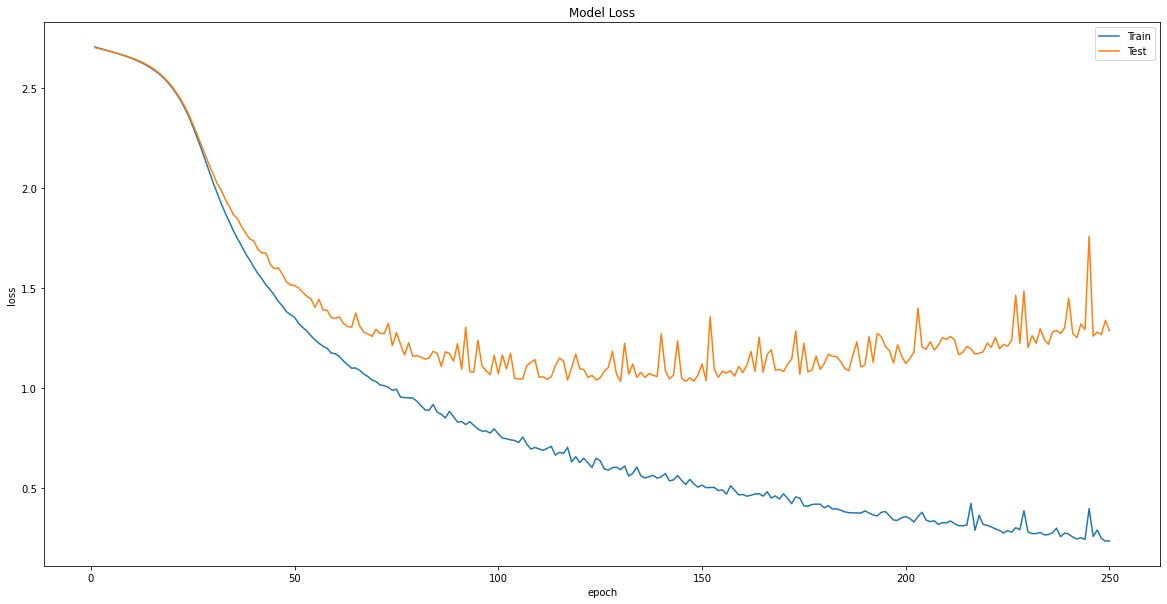

In [76]:
# Save the plot for losses
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_ls) + 1), train_ls, label='Train')
plt.plot(range(1, len(test_ls) + 1), test_ls, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_SGD_qn1_loss_no_dropout.pdf'
)

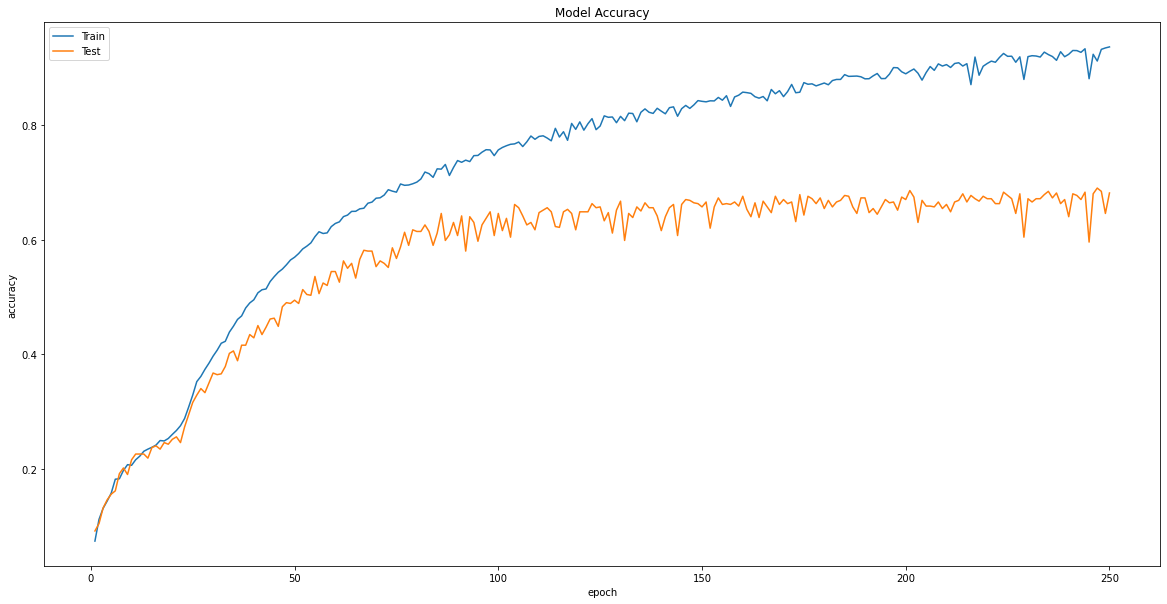

In [77]:
# Save the plot for accuracies
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_SGD_qn1_accuracy_no_dropout.pdf'
)

## Question 2

In [78]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import nltk

nltk.download('punkt')

MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
EMBEDDING_SIZE = 20
FILTER_SHAPE1 = [20, 20]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)


def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text


def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict


def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x


def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size


x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[nltk_data] Downloading package punkt to C:\Users\Shearman
[nltk_data]     Chua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [79]:
# Build model
tf.keras.backend.set_floatx('float32')

class WordCNN(Model):
    def __init__(self, vocab_size=256):
        super(WordCNN, self).__init__()
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        self.reshape = layers.Reshape((MAX_DOCUMENT_LENGTH, EMBEDDING_SIZE, 1))
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        # forward
        x = self.embedding(x)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

model = WordCNN(vocab_size)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

start = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
end = time.time()
print("Time elapsed in seconds: " + str(end - start))
run_times['CNN_word_Adam'] = end - start

Epoch 1, Loss: 2.1557042598724365, Accuracy: 0.2264285683631897, Test Loss: 1.3403509855270386, Test Accuracy: 0.5114285945892334
Epoch 2, Loss: 0.9102548360824585, Accuracy: 0.6742857098579407, Test Loss: 0.9012770056724548, Test Accuracy: 0.691428542137146
Epoch 3, Loss: 0.2590982913970947, Accuracy: 0.9242857098579407, Test Loss: 0.9628133773803711, Test Accuracy: 0.7785714268684387
Epoch 4, Loss: 0.09719962626695633, Accuracy: 0.9753571152687073, Test Loss: 1.0016762018203735, Test Accuracy: 0.7814285755157471
Epoch 5, Loss: 0.04922053590416908, Accuracy: 0.9891071319580078, Test Loss: 1.0844529867172241, Test Accuracy: 0.7771428823471069
Epoch 6, Loss: 0.031154103577136993, Accuracy: 0.993571400642395, Test Loss: 1.1152218580245972, Test Accuracy: 0.7785714268684387
Epoch 7, Loss: 0.022096997126936913, Accuracy: 0.9955357313156128, Test Loss: 1.2684277296066284, Test Accuracy: 0.7714285850524902
Epoch 8, Loss: 0.01691596396267414, Accuracy: 0.9967857003211975, Test Loss: 1.2277079

Epoch 64, Loss: 0.5197479724884033, Accuracy: 0.9632142782211304, Test Loss: 3.799051284790039, Test Accuracy: 0.7557142972946167
Epoch 65, Loss: 0.4151594936847687, Accuracy: 0.970714271068573, Test Loss: 3.808163642883301, Test Accuracy: 0.7514285445213318
Epoch 66, Loss: 0.5416406989097595, Accuracy: 0.9608928561210632, Test Loss: 3.2565841674804688, Test Accuracy: 0.7857142686843872
Epoch 67, Loss: 0.38160276412963867, Accuracy: 0.9703571200370789, Test Loss: 3.250234603881836, Test Accuracy: 0.7828571200370789
Epoch 68, Loss: 0.35905978083610535, Accuracy: 0.9748214483261108, Test Loss: 3.213141679763794, Test Accuracy: 0.7900000214576721
Epoch 69, Loss: 0.431265652179718, Accuracy: 0.9705356955528259, Test Loss: 3.318880081176758, Test Accuracy: 0.7828571200370789
Epoch 70, Loss: 0.39158394932746887, Accuracy: 0.9735714197158813, Test Loss: 3.0612497329711914, Test Accuracy: 0.7942857146263123
Epoch 71, Loss: 0.278239369392395, Accuracy: 0.9817857146263123, Test Loss: 3.463742494

Epoch 127, Loss: 0.5594145059585571, Accuracy: 0.9639285802841187, Test Loss: 3.2772653102874756, Test Accuracy: 0.7842857241630554
Epoch 128, Loss: 0.6839202642440796, Accuracy: 0.956428587436676, Test Loss: 3.3016178607940674, Test Accuracy: 0.7828571200370789
Epoch 129, Loss: 0.532025933265686, Accuracy: 0.9664285778999329, Test Loss: 3.1327435970306396, Test Accuracy: 0.795714259147644
Epoch 130, Loss: 0.45417043566703796, Accuracy: 0.970714271068573, Test Loss: 2.8729941844940186, Test Accuracy: 0.8114285469055176
Epoch 131, Loss: 0.408753901720047, Accuracy: 0.9735714197158813, Test Loss: 3.1912100315093994, Test Accuracy: 0.7914285659790039
Epoch 132, Loss: 0.31540724635124207, Accuracy: 0.979107141494751, Test Loss: 3.4523799419403076, Test Accuracy: 0.7814285755157471
Epoch 133, Loss: 0.40703973174095154, Accuracy: 0.9730356931686401, Test Loss: 3.094937562942505, Test Accuracy: 0.795714259147644
Epoch 134, Loss: 0.5515930652618408, Accuracy: 0.9642857313156128, Test Loss: 3.4

Epoch 190, Loss: 0.43988171219825745, Accuracy: 0.9712499976158142, Test Loss: 3.0090761184692383, Test Accuracy: 0.8042857050895691
Epoch 191, Loss: 0.37047746777534485, Accuracy: 0.9760714173316956, Test Loss: 3.075587511062622, Test Accuracy: 0.7971428632736206
Epoch 192, Loss: 0.3837496042251587, Accuracy: 0.9755356907844543, Test Loss: 3.0679588317871094, Test Accuracy: 0.7971428632736206
Epoch 193, Loss: 0.38179638981819153, Accuracy: 0.9755356907844543, Test Loss: 3.0682907104492188, Test Accuracy: 0.7971428632736206
Epoch 194, Loss: 0.38076403737068176, Accuracy: 0.9755356907844543, Test Loss: 3.068514108657837, Test Accuracy: 0.7971428632736206
Epoch 195, Loss: 0.3837794363498688, Accuracy: 0.9755356907844543, Test Loss: 3.06888484954834, Test Accuracy: 0.7971428632736206
Epoch 196, Loss: 0.3796609044075012, Accuracy: 0.9755356907844543, Test Loss: 3.0689642429351807, Test Accuracy: 0.7971428632736206
Epoch 197, Loss: 0.38046780228614807, Accuracy: 0.9755356907844543, Test Los

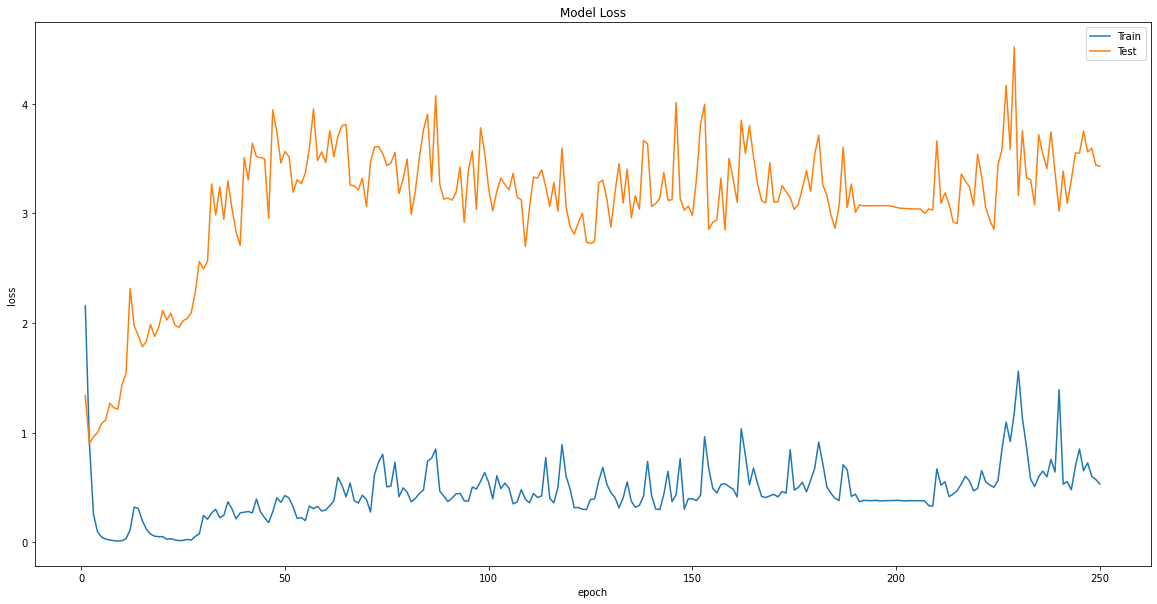

In [80]:
# Save the plot for losses
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_ls) + 1), train_ls, label='Train')
plt.plot(range(1, len(test_ls) + 1), test_ls, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_Adam_qn2_loss_no_dropout.pdf'
)

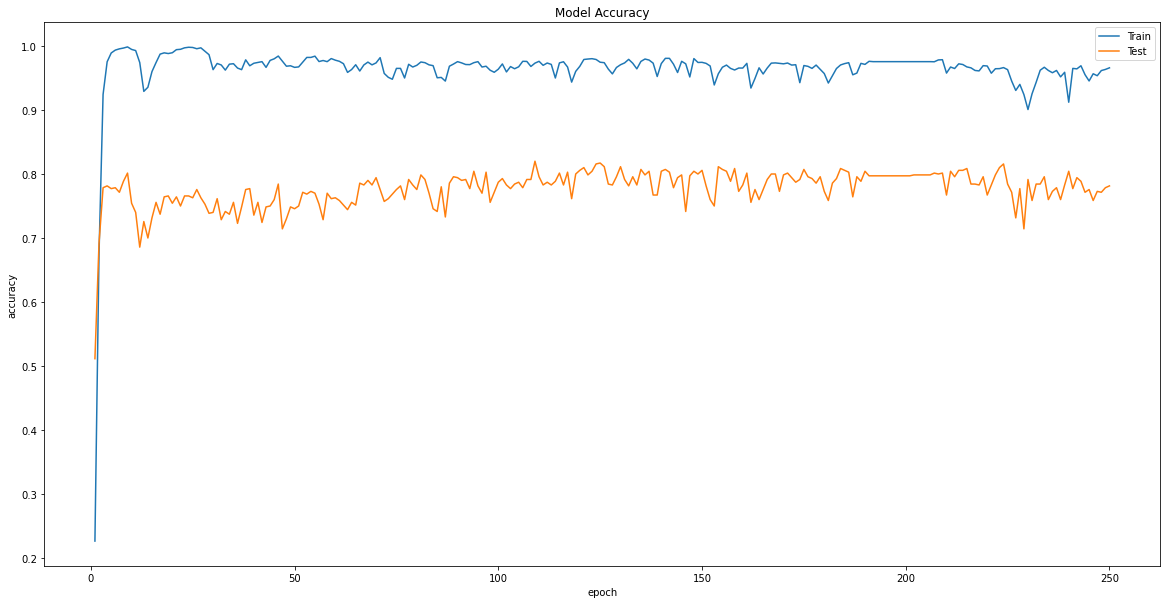

In [81]:
# Save the plot for accuracies
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_Adam_qn2_accuracy_no_dropout.pdf'
)

In [82]:
run_times

{'CNN_char_Adam': 148.24432277679443,
 'CNN_char_SGD': 123.15405297279358,
 'CNN_word_Adam': 234.50304460525513}

In [83]:
# Build model
tf.keras.backend.set_floatx('float32')

class WordCNN(Model):
    def __init__(self, vocab_size=256):
        super(WordCNN, self).__init__()
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        self.reshape = layers.Reshape((MAX_DOCUMENT_LENGTH, EMBEDDING_SIZE, 1))
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        # forward
        x = self.embedding(x)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

model = WordCNN(vocab_size)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

start = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
end = time.time()
print("Time elapsed in seconds: " + str(end - start))
run_times['CNN_word_SGD'] = end - start

Epoch 1, Loss: 2.7045392990112305, Accuracy: 0.06964285671710968, Test Loss: 2.7025563716888428, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.700359582901001, Accuracy: 0.07321428507566452, Test Loss: 2.6986501216888428, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6963868141174316, Accuracy: 0.0714285746216774, Test Loss: 2.6949985027313232, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.692751169204712, Accuracy: 0.0714285746216774, Test Loss: 2.691701650619507, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.6894643306732178, Accuracy: 0.0714285746216774, Test Loss: 2.6886444091796875, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.686347723007202, Accuracy: 0.0714285746216774, Test Loss: 2.6857211589813232, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.6834757328033447, Accuracy: 0.0714285746216774, Test Loss: 2.6828997135162354, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.68058443069458, Accuracy: 0.0714285746216774, Test Loss: 2.6801340579986572

Epoch 64, Loss: 2.6032943725585938, Accuracy: 0.10446428507566452, Test Loss: 2.594905138015747, Test Accuracy: 0.10285714268684387
Epoch 65, Loss: 2.601864814758301, Accuracy: 0.10374999791383743, Test Loss: 2.596120834350586, Test Accuracy: 0.10285714268684387
Epoch 66, Loss: 2.6008851528167725, Accuracy: 0.10875000059604645, Test Loss: 2.5933496952056885, Test Accuracy: 0.10428571701049805
Epoch 67, Loss: 2.600919723510742, Accuracy: 0.10678571462631226, Test Loss: 2.5929348468780518, Test Accuracy: 0.1014285683631897
Epoch 68, Loss: 2.599372148513794, Accuracy: 0.10875000059604645, Test Loss: 2.5915725231170654, Test Accuracy: 0.11428571492433548
Epoch 69, Loss: 2.5986337661743164, Accuracy: 0.10499999672174454, Test Loss: 2.590359926223755, Test Accuracy: 0.11428571492433548
Epoch 70, Loss: 2.5969743728637695, Accuracy: 0.1103571429848671, Test Loss: 2.591710329055786, Test Accuracy: 0.10428571701049805
Epoch 71, Loss: 2.5965335369110107, Accuracy: 0.10910714417695999, Test Loss: 

Epoch 126, Loss: 2.580192804336548, Accuracy: 0.11357142776250839, Test Loss: 2.5775673389434814, Test Accuracy: 0.09428571164608002
Epoch 127, Loss: 2.5789992809295654, Accuracy: 0.11642856895923615, Test Loss: 2.5801947116851807, Test Accuracy: 0.08857142925262451
Epoch 128, Loss: 2.578871965408325, Accuracy: 0.1173214316368103, Test Loss: 2.5760281085968018, Test Accuracy: 0.11428571492433548
Epoch 129, Loss: 2.579378366470337, Accuracy: 0.11517857015132904, Test Loss: 2.574174165725708, Test Accuracy: 0.10285714268684387
Epoch 130, Loss: 2.5785956382751465, Accuracy: 0.11321428418159485, Test Loss: 2.574187755584717, Test Accuracy: 0.10857142508029938
Epoch 131, Loss: 2.577768564224243, Accuracy: 0.11714285612106323, Test Loss: 2.576390027999878, Test Accuracy: 0.10571428388357162
Epoch 132, Loss: 2.577548027038574, Accuracy: 0.1173214316368103, Test Loss: 2.574357748031616, Test Accuracy: 0.11714285612106323
Epoch 133, Loss: 2.5766401290893555, Accuracy: 0.1160714253783226, Test L

Epoch 188, Loss: 2.537290334701538, Accuracy: 0.14946427941322327, Test Loss: 2.5382778644561768, Test Accuracy: 0.1485714316368103
Epoch 189, Loss: 2.53532075881958, Accuracy: 0.15232142806053162, Test Loss: 2.534846544265747, Test Accuracy: 0.15000000596046448
Epoch 190, Loss: 2.5323379039764404, Accuracy: 0.15160714089870453, Test Loss: 2.5327646732330322, Test Accuracy: 0.14571428298950195
Epoch 191, Loss: 2.5297110080718994, Accuracy: 0.15678571164608002, Test Loss: 2.533355951309204, Test Accuracy: 0.15000000596046448
Epoch 192, Loss: 2.5278570652008057, Accuracy: 0.15642857551574707, Test Loss: 2.5276944637298584, Test Accuracy: 0.15142856538295746
Epoch 193, Loss: 2.5238494873046875, Accuracy: 0.16035714745521545, Test Loss: 2.524850606918335, Test Accuracy: 0.15000000596046448
Epoch 194, Loss: 2.5207834243774414, Accuracy: 0.16875000298023224, Test Loss: 2.5228588581085205, Test Accuracy: 0.15000000596046448
Epoch 195, Loss: 2.517674446105957, Accuracy: 0.16535714268684387, Te

Epoch 250, Loss: 1.862909197807312, Accuracy: 0.3423214256763458, Test Loss: 1.8682078123092651, Test Accuracy: 0.345714271068573
Time elapsed in seconds: 124.69450163841248


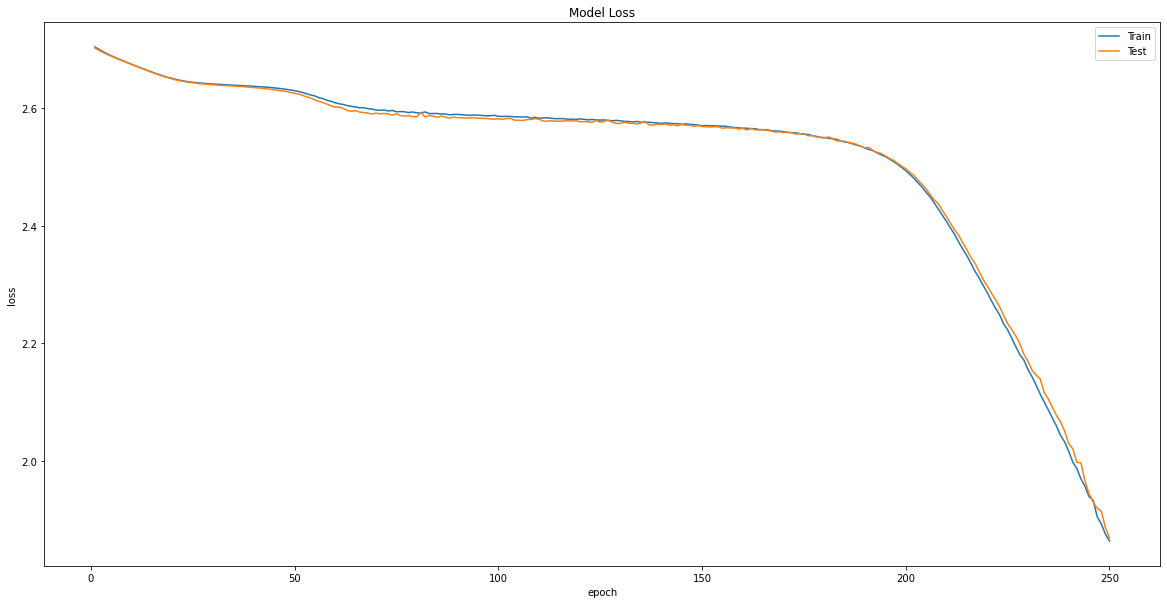

In [84]:
# Save the plot for losses
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_ls) + 1), train_ls, label='Train')
plt.plot(range(1, len(test_ls) + 1), test_ls, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_SGD_qn2_loss_no_dropout.pdf'
)

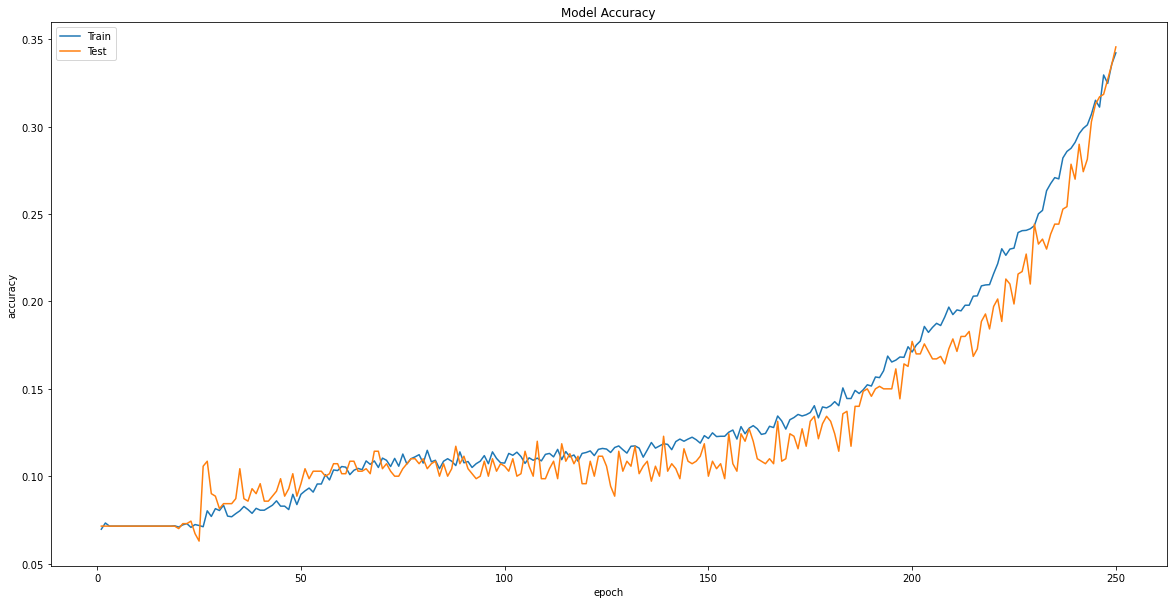

In [85]:
# Save the plot for accuracies
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_SGD_qn2_accuracy_no_dropout.pdf'
)

In [86]:
run_times

{'CNN_char_Adam': 148.24432277679443,
 'CNN_char_SGD': 123.15405297279358,
 'CNN_word_Adam': 234.50304460525513,
 'CNN_word_SGD': 124.69450163841248}

## Question 3

In [87]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import matplotlib.pyplot as plt
import time

MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE = 20
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [89]:
# Build model
tf.keras.backend.set_floatx('float32')

class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

start = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
end = time.time()
print("Time elapsed in seconds: " + str(end - start))
run_times['RNN_char_Adam'] = end - start

Epoch 1, Loss: 2.6480233669281006, Accuracy: 0.08250000327825546, Test Loss: 2.60834002494812, Test Accuracy: 0.10285714268684387
Epoch 2, Loss: 2.5840463638305664, Accuracy: 0.12482143193483353, Test Loss: 2.5467889308929443, Test Accuracy: 0.13571429252624512
Epoch 3, Loss: 2.4383275508880615, Accuracy: 0.1683928519487381, Test Loss: 2.396197557449341, Test Accuracy: 0.19857142865657806
Epoch 4, Loss: 2.1809635162353516, Accuracy: 0.23250000178813934, Test Loss: 2.146192789077759, Test Accuracy: 0.2442857176065445
Epoch 5, Loss: 1.9585715532302856, Accuracy: 0.30446428060531616, Test Loss: 1.9131450653076172, Test Accuracy: 0.34142857789993286
Epoch 6, Loss: 1.7260792255401611, Accuracy: 0.385357141494751, Test Loss: 1.6904410123825073, Test Accuracy: 0.427142858505249
Epoch 7, Loss: 1.5563979148864746, Accuracy: 0.45375001430511475, Test Loss: 1.5518970489501953, Test Accuracy: 0.47428572177886963
Epoch 8, Loss: 1.414172649383545, Accuracy: 0.5026785731315613, Test Loss: 1.467307925

Epoch 64, Loss: 0.3845292329788208, Accuracy: 0.8717857003211975, Test Loss: 1.4157929420471191, Test Accuracy: 0.6814285516738892
Epoch 65, Loss: 0.37494686245918274, Accuracy: 0.8824999928474426, Test Loss: 1.2900644540786743, Test Accuracy: 0.6728571653366089
Epoch 66, Loss: 0.35376930236816406, Accuracy: 0.8869642615318298, Test Loss: 1.350459098815918, Test Accuracy: 0.677142858505249
Epoch 67, Loss: 0.37610924243927, Accuracy: 0.876964271068573, Test Loss: 1.3286103010177612, Test Accuracy: 0.6842857003211975
Epoch 68, Loss: 1.5206630229949951, Accuracy: 0.6449999809265137, Test Loss: 1.96332585811615, Test Accuracy: 0.44428572058677673
Epoch 69, Loss: 1.2080124616622925, Accuracy: 0.6116071343421936, Test Loss: 1.2894388437271118, Test Accuracy: 0.5985714197158813
Epoch 70, Loss: 0.8680089712142944, Accuracy: 0.7178571224212646, Test Loss: 1.1692276000976562, Test Accuracy: 0.6499999761581421
Epoch 71, Loss: 0.7435201406478882, Accuracy: 0.7569642663002014, Test Loss: 1.14280390

Epoch 127, Loss: 0.26220375299453735, Accuracy: 0.9225000143051147, Test Loss: 1.3910282850265503, Test Accuracy: 0.6957142949104309
Epoch 128, Loss: 0.3620099723339081, Accuracy: 0.8837500214576721, Test Loss: 1.452807068824768, Test Accuracy: 0.6957142949104309
Epoch 129, Loss: 0.3218825161457062, Accuracy: 0.8971428275108337, Test Loss: 1.3988252878189087, Test Accuracy: 0.6942856907844543
Epoch 130, Loss: 0.28342610597610474, Accuracy: 0.9085714221000671, Test Loss: 1.452191948890686, Test Accuracy: 0.7028571367263794
Epoch 131, Loss: 0.2542729079723358, Accuracy: 0.9237499833106995, Test Loss: 1.4106650352478027, Test Accuracy: 0.7014285922050476
Epoch 132, Loss: 0.2770290970802307, Accuracy: 0.9133928418159485, Test Loss: 1.5078507661819458, Test Accuracy: 0.6985714435577393
Epoch 133, Loss: 0.25043222308158875, Accuracy: 0.925178587436676, Test Loss: 1.464249610900879, Test Accuracy: 0.6871428489685059
Epoch 134, Loss: 0.23843695223331451, Accuracy: 0.9278571605682373, Test Loss

Epoch 190, Loss: 0.19372177124023438, Accuracy: 0.9407142996788025, Test Loss: 1.6029237508773804, Test Accuracy: 0.7057142853736877
Epoch 191, Loss: 0.19114789366722107, Accuracy: 0.9419642686843872, Test Loss: 1.7011326551437378, Test Accuracy: 0.691428542137146
Epoch 192, Loss: 0.3281925618648529, Accuracy: 0.8935714364051819, Test Loss: 1.7338026762008667, Test Accuracy: 0.6842857003211975
Epoch 193, Loss: 0.4106304347515106, Accuracy: 0.8607142567634583, Test Loss: 1.575494647026062, Test Accuracy: 0.7014285922050476
Epoch 194, Loss: 0.27217307686805725, Accuracy: 0.9108928442001343, Test Loss: 1.6337989568710327, Test Accuracy: 0.7099999785423279
Epoch 195, Loss: 0.22585953772068024, Accuracy: 0.9276785850524902, Test Loss: 1.5675066709518433, Test Accuracy: 0.7157142758369446
Epoch 196, Loss: 0.20137882232666016, Accuracy: 0.9367856979370117, Test Loss: 1.636264443397522, Test Accuracy: 0.7085714340209961
Epoch 197, Loss: 0.20862165093421936, Accuracy: 0.9325000047683716, Test L

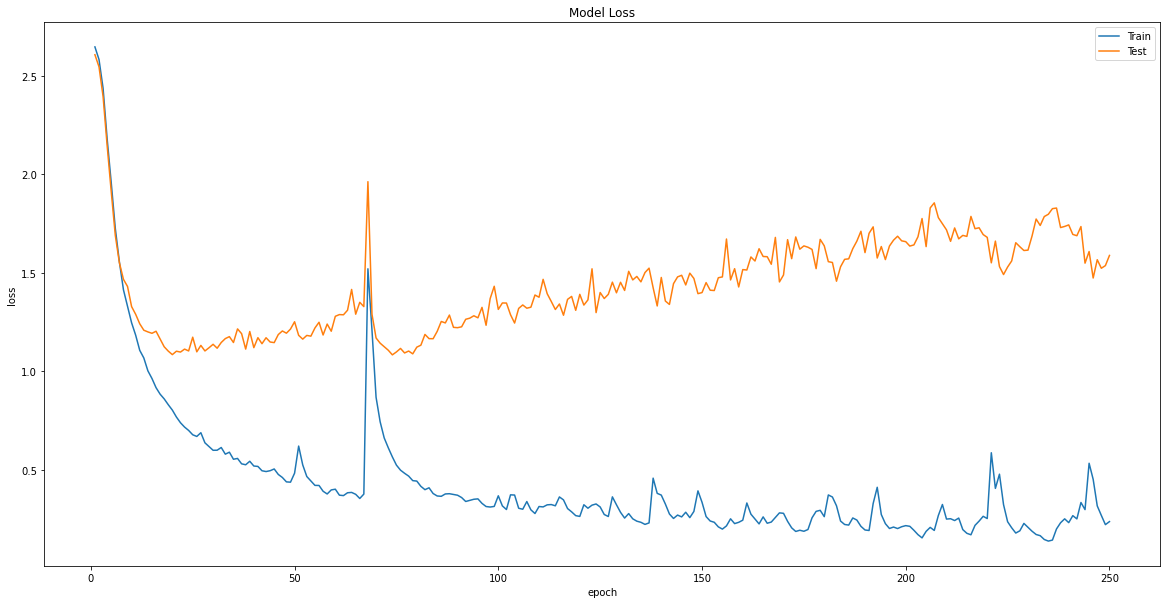

In [90]:
# Save the plot for losses
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_ls) + 1), train_ls, label='Train')
plt.plot(range(1, len(test_ls) + 1), test_ls, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_Adam_qn3_loss_no_dropout.pdf'
)

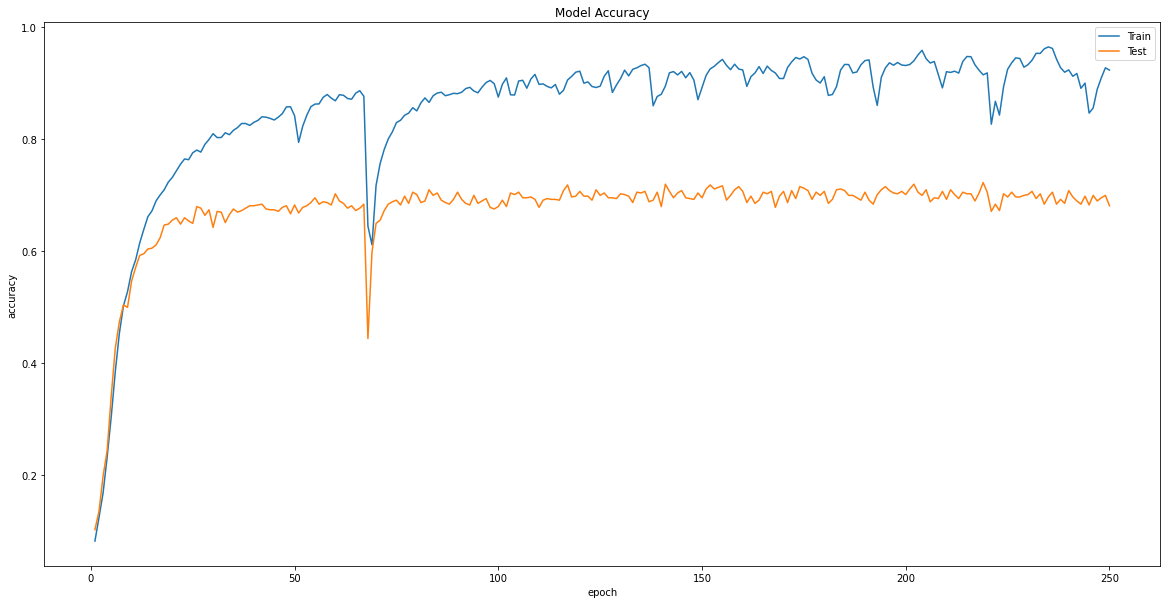

In [91]:
# Save the plot for accuracies
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_Adam_qn3_accuracy_no_dropout.pdf'
)

In [92]:
# Build model
tf.keras.backend.set_floatx('float32')

class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

start = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
end = time.time()
print("Time elapsed in seconds: " + str(end - start))
run_times['RNN_char_SGD'] = end - start

Epoch 1, Loss: 2.7040140628814697, Accuracy: 0.06053571403026581, Test Loss: 2.70139479637146, Test Accuracy: 0.058571428060531616
Epoch 2, Loss: 2.6994576454162598, Accuracy: 0.06267856806516647, Test Loss: 2.6970250606536865, Test Accuracy: 0.058571428060531616
Epoch 3, Loss: 2.695502519607544, Accuracy: 0.06535714119672775, Test Loss: 2.6932449340820312, Test Accuracy: 0.058571428060531616
Epoch 4, Loss: 2.6920976638793945, Accuracy: 0.06446428596973419, Test Loss: 2.6899254322052, Test Accuracy: 0.05428571254014969
Epoch 5, Loss: 2.6890294551849365, Accuracy: 0.06446428596973419, Test Loss: 2.686974287033081, Test Accuracy: 0.055714286863803864
Epoch 6, Loss: 2.686316967010498, Accuracy: 0.06607142835855484, Test Loss: 2.6843204498291016, Test Accuracy: 0.05714285746216774
Epoch 7, Loss: 2.6837873458862305, Accuracy: 0.06803571432828903, Test Loss: 2.681891441345215, Test Accuracy: 0.05999999865889549
Epoch 8, Loss: 2.681544065475464, Accuracy: 0.06660714000463486, Test Loss: 2.679

Epoch 64, Loss: 2.633737325668335, Accuracy: 0.09196428209543228, Test Loss: 2.6340088844299316, Test Accuracy: 0.08571428805589676
Epoch 65, Loss: 2.6332459449768066, Accuracy: 0.09428571164608002, Test Loss: 2.633629560470581, Test Accuracy: 0.08714285492897034
Epoch 66, Loss: 2.6328980922698975, Accuracy: 0.09375, Test Loss: 2.6332600116729736, Test Accuracy: 0.09142857044935226
Epoch 67, Loss: 2.6324658393859863, Accuracy: 0.09339285641908646, Test Loss: 2.6328887939453125, Test Accuracy: 0.09000000357627869
Epoch 68, Loss: 2.6320278644561768, Accuracy: 0.09482143074274063, Test Loss: 2.6325271129608154, Test Accuracy: 0.09000000357627869
Epoch 69, Loss: 2.6318178176879883, Accuracy: 0.09339285641908646, Test Loss: 2.632171392440796, Test Accuracy: 0.08571428805589676
Epoch 70, Loss: 2.631316661834717, Accuracy: 0.09482143074274063, Test Loss: 2.6318259239196777, Test Accuracy: 0.08428571373224258
Epoch 71, Loss: 2.631049871444702, Accuracy: 0.09375, Test Loss: 2.6314830780029297, 

Epoch 127, Loss: 2.6162099838256836, Accuracy: 0.09571428596973419, Test Loss: 2.617017984390259, Test Accuracy: 0.08428571373224258
Epoch 128, Loss: 2.6161603927612305, Accuracy: 0.09375, Test Loss: 2.6168298721313477, Test Accuracy: 0.08428571373224258
Epoch 129, Loss: 2.615952491760254, Accuracy: 0.0949999988079071, Test Loss: 2.616652727127075, Test Accuracy: 0.08428571373224258
Epoch 130, Loss: 2.615593194961548, Accuracy: 0.09571428596973419, Test Loss: 2.616474151611328, Test Accuracy: 0.08571428805589676
Epoch 131, Loss: 2.6154801845550537, Accuracy: 0.09410714358091354, Test Loss: 2.616291046142578, Test Accuracy: 0.08571428805589676
Epoch 132, Loss: 2.6152520179748535, Accuracy: 0.09446428716182709, Test Loss: 2.616119384765625, Test Accuracy: 0.08428571373224258
Epoch 133, Loss: 2.6152396202087402, Accuracy: 0.09267856925725937, Test Loss: 2.6159536838531494, Test Accuracy: 0.08428571373224258
Epoch 134, Loss: 2.6148626804351807, Accuracy: 0.09464285522699356, Test Loss: 2.6

Epoch 190, Loss: 2.607795476913452, Accuracy: 0.09660714119672775, Test Loss: 2.609222412109375, Test Accuracy: 0.08285713940858841
Epoch 191, Loss: 2.6075522899627686, Accuracy: 0.09535714238882065, Test Loss: 2.6091501712799072, Test Accuracy: 0.08285713940858841
Epoch 192, Loss: 2.6077001094818115, Accuracy: 0.09571428596973419, Test Loss: 2.6090707778930664, Test Accuracy: 0.08285713940858841
Epoch 193, Loss: 2.6076807975769043, Accuracy: 0.09589285403490067, Test Loss: 2.6090009212493896, Test Accuracy: 0.08285713940858841
Epoch 194, Loss: 2.607581377029419, Accuracy: 0.09714286029338837, Test Loss: 2.608924627304077, Test Accuracy: 0.08285713940858841
Epoch 195, Loss: 2.6074326038360596, Accuracy: 0.09678571671247482, Test Loss: 2.608854055404663, Test Accuracy: 0.08285713940858841
Epoch 196, Loss: 2.6072700023651123, Accuracy: 0.09642857313156128, Test Loss: 2.608774185180664, Test Accuracy: 0.08285713940858841
Epoch 197, Loss: 2.6071317195892334, Accuracy: 0.09678571671247482, 

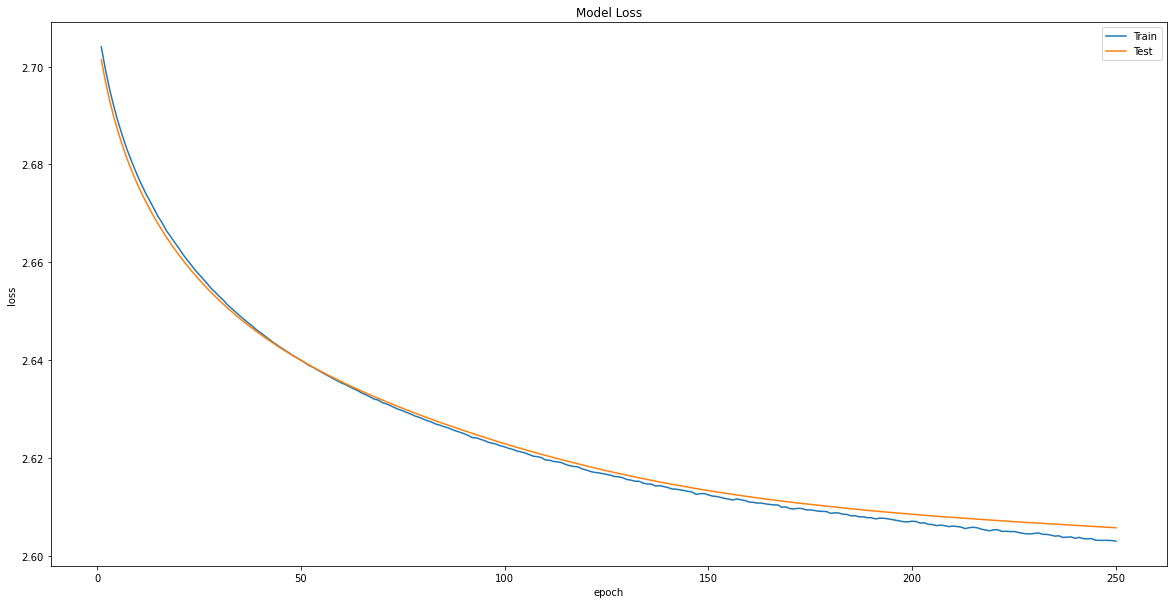

In [93]:
# Save the plot for losses
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_ls) + 1), train_ls, label='Train')
plt.plot(range(1, len(test_ls) + 1), test_ls, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_SGD_qn3_loss_no_dropout.pdf'
)

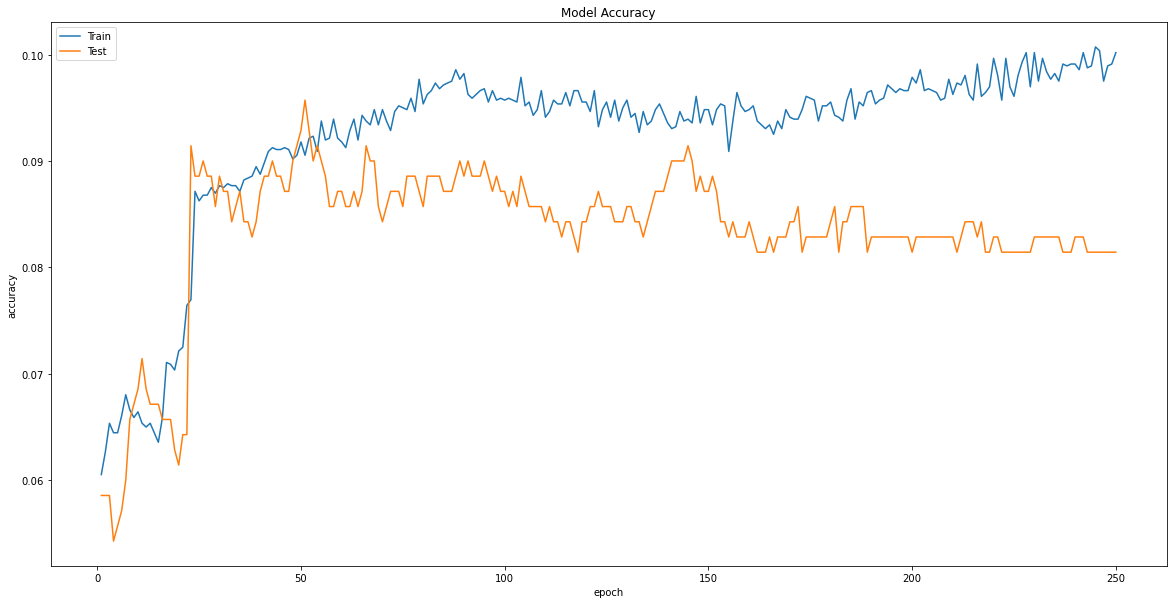

In [94]:
# Save the plot for accuracies
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_SGD_qn3_accuracy_no_dropout.pdf'
)

In [95]:
run_times

{'CNN_char_Adam': 148.24432277679443,
 'CNN_char_SGD': 123.15405297279358,
 'CNN_word_Adam': 234.50304460525513,
 'CNN_word_SGD': 124.69450163841248,
 'RNN_char_Adam': 1607.652664899826,
 'RNN_char_SGD': 1588.59663271904}

## Question 4

In [96]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import nltk

nltk.download('punkt')

MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE = 20
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)


def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text


def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict


def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x


def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size


x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[nltk_data] Downloading package punkt to C:\Users\Shearman
[nltk_data]     Chua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [97]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

start = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
end = time.time()
print("Time elapsed in seconds: " + str(end - start))
run_times['RNN_word_Adam'] = end - start

Epoch 1, Loss: 2.6653292179107666, Accuracy: 0.07035714387893677, Test Loss: 2.6457607746124268, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.646775960922241, Accuracy: 0.07410714030265808, Test Loss: 2.6485114097595215, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.600168466567993, Accuracy: 0.09982142597436905, Test Loss: 2.3566651344299316, Test Accuracy: 0.14142857491970062
Epoch 4, Loss: 1.911570429801941, Accuracy: 0.2766071557998657, Test Loss: 1.5455876588821411, Test Accuracy: 0.4099999964237213
Epoch 5, Loss: 1.1658190488815308, Accuracy: 0.5714285969734192, Test Loss: 1.0913875102996826, Test Accuracy: 0.6385714411735535
Epoch 6, Loss: 0.7030837535858154, Accuracy: 0.7317857146263123, Test Loss: 0.8236930966377258, Test Accuracy: 0.6899999976158142
Epoch 7, Loss: 0.44173669815063477, Accuracy: 0.847678542137146, Test Loss: 0.7060866951942444, Test Accuracy: 0.7699999809265137
Epoch 8, Loss: 0.23622621595859528, Accuracy: 0.9369642734527588, Test Loss: 0.6760755181

Epoch 68, Loss: 0.00019477003661449999, Accuracy: 1.0, Test Loss: 1.0089613199234009, Test Accuracy: 0.8500000238418579
Epoch 69, Loss: 0.00018828973406925797, Accuracy: 1.0, Test Loss: 1.0125633478164673, Test Accuracy: 0.8500000238418579
Epoch 70, Loss: 0.00018215901218354702, Accuracy: 1.0, Test Loss: 1.0162944793701172, Test Accuracy: 0.8500000238418579
Epoch 71, Loss: 0.00017630981164984405, Accuracy: 1.0, Test Loss: 1.0206034183502197, Test Accuracy: 0.8500000238418579
Epoch 72, Loss: 0.00017057992226909846, Accuracy: 1.0, Test Loss: 1.0247232913970947, Test Accuracy: 0.8471428751945496
Epoch 73, Loss: 0.00016521039651706815, Accuracy: 1.0, Test Loss: 1.0289374589920044, Test Accuracy: 0.8485714197158813
Epoch 74, Loss: 0.00015997968148440123, Accuracy: 1.0, Test Loss: 1.033059000968933, Test Accuracy: 0.8485714197158813
Epoch 75, Loss: 0.0001550100714666769, Accuracy: 1.0, Test Loss: 1.0375148057937622, Test Accuracy: 0.8485714197158813
Epoch 76, Loss: 0.00015010412607807666, Ac

Epoch 137, Loss: 2.8351438231766224e-05, Accuracy: 1.0, Test Loss: 1.2711251974105835, Test Accuracy: 0.8500000238418579
Epoch 138, Loss: 2.7647107344819233e-05, Accuracy: 1.0, Test Loss: 1.2749706506729126, Test Accuracy: 0.8500000238418579
Epoch 139, Loss: 2.69795873464318e-05, Accuracy: 1.0, Test Loss: 1.2798670530319214, Test Accuracy: 0.8500000238418579
Epoch 140, Loss: 2.6331063054385595e-05, Accuracy: 1.0, Test Loss: 1.2853543758392334, Test Accuracy: 0.8500000238418579
Epoch 141, Loss: 2.5665718567324802e-05, Accuracy: 1.0, Test Loss: 1.2907792329788208, Test Accuracy: 0.8485714197158813
Epoch 142, Loss: 2.5034369173226878e-05, Accuracy: 1.0, Test Loss: 1.295524001121521, Test Accuracy: 0.8485714197158813
Epoch 143, Loss: 2.4409842808381654e-05, Accuracy: 1.0, Test Loss: 1.3004860877990723, Test Accuracy: 0.8485714197158813
Epoch 144, Loss: 2.3825716198189184e-05, Accuracy: 1.0, Test Loss: 1.3048439025878906, Test Accuracy: 0.8485714197158813
Epoch 145, Loss: 2.3246944692800753

Epoch 206, Loss: 5.278919161355589e-06, Accuracy: 1.0, Test Loss: 1.5505846738815308, Test Accuracy: 0.8414285778999329
Epoch 207, Loss: 5.1571855692600366e-06, Accuracy: 1.0, Test Loss: 1.5554405450820923, Test Accuracy: 0.8414285778999329
Epoch 208, Loss: 5.036579750594683e-06, Accuracy: 1.0, Test Loss: 1.5598993301391602, Test Accuracy: 0.8414285778999329
Epoch 209, Loss: 4.917837486573262e-06, Accuracy: 1.0, Test Loss: 1.5642963647842407, Test Accuracy: 0.8414285778999329
Epoch 210, Loss: 4.801387149200309e-06, Accuracy: 1.0, Test Loss: 1.5684114694595337, Test Accuracy: 0.8414285778999329
Epoch 211, Loss: 4.68678581455606e-06, Accuracy: 1.0, Test Loss: 1.5725923776626587, Test Accuracy: 0.8414285778999329
Epoch 212, Loss: 4.575796538119903e-06, Accuracy: 1.0, Test Loss: 1.5768343210220337, Test Accuracy: 0.8399999737739563
Epoch 213, Loss: 4.4649627852777485e-06, Accuracy: 1.0, Test Loss: 1.5809303522109985, Test Accuracy: 0.8399999737739563
Epoch 214, Loss: 4.3596746763796546e-06

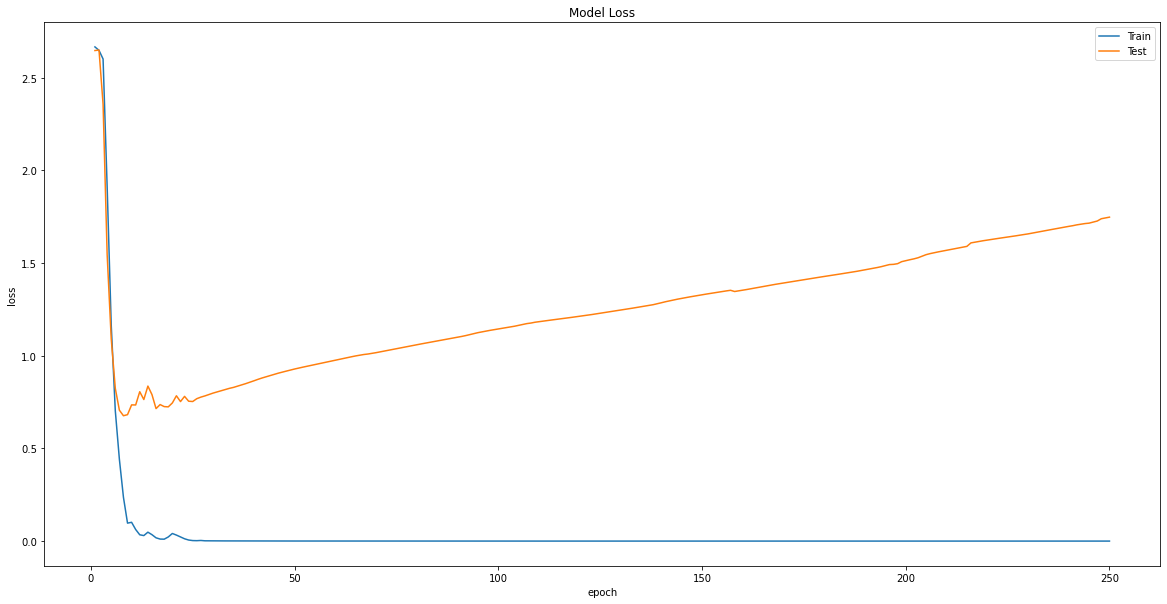

In [98]:
# Save the plot for losses
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_ls) + 1), train_ls, label='Train')
plt.plot(range(1, len(test_ls) + 1), test_ls, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_Adam_qn4_loss_no_dropout.pdf'
)

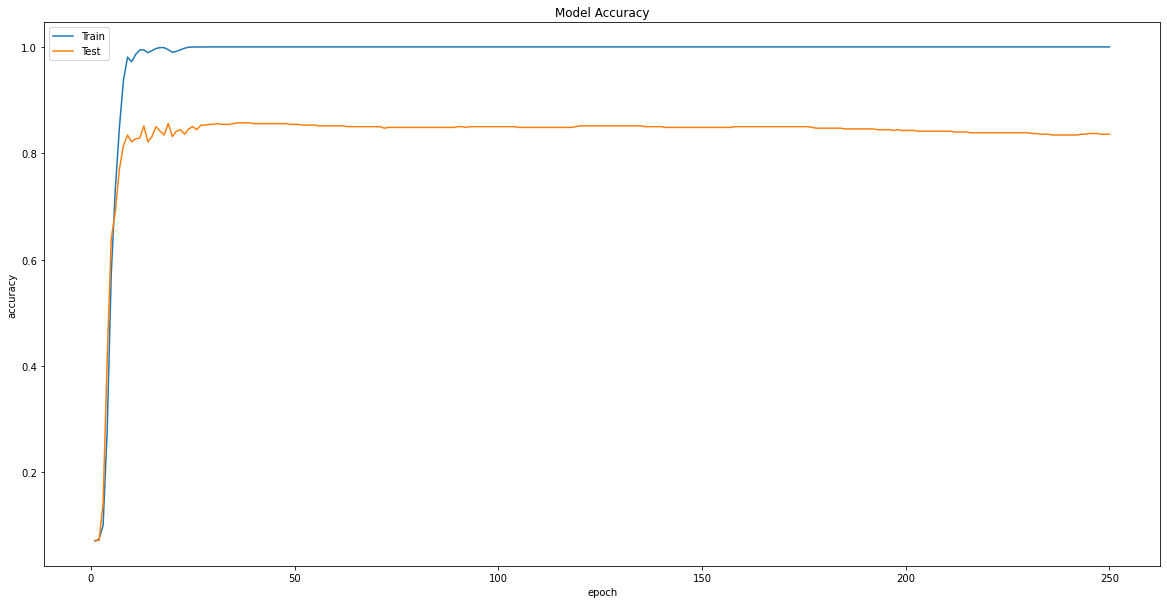

In [99]:
# Save the plot for accuracies
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_Adam_qn4_accuracy_no_dropout.pdf'
)

In [100]:
model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

start = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
end = time.time()
print("Time elapsed in seconds: " + str(end - start))
run_times['RNN_word_SGD'] = end - start

Epoch 1, Loss: 2.7058629989624023, Accuracy: 0.0682142823934555, Test Loss: 2.7022836208343506, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6995770931243896, Accuracy: 0.07160714268684387, Test Loss: 2.6969118118286133, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6946465969085693, Accuracy: 0.07160714268684387, Test Loss: 2.69262433052063, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.6906163692474365, Accuracy: 0.07160714268684387, Test Loss: 2.6890745162963867, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.6872451305389404, Accuracy: 0.07160714268684387, Test Loss: 2.686089515686035, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.6844515800476074, Accuracy: 0.07160714268684387, Test Loss: 2.6835262775421143, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.68190598487854, Accuracy: 0.07160714268684387, Test Loss: 2.681260347366333, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.679734945297241, Accuracy: 0.07160714268684387, Test Loss: 2.679248809814

Epoch 64, Loss: 2.6461939811706543, Accuracy: 0.06910714507102966, Test Loss: 2.646167039871216, Test Accuracy: 0.07285714149475098
Epoch 65, Loss: 2.6460683345794678, Accuracy: 0.06857142597436905, Test Loss: 2.646017551422119, Test Accuracy: 0.07285714149475098
Epoch 66, Loss: 2.6459128856658936, Accuracy: 0.07196428626775742, Test Loss: 2.645871877670288, Test Accuracy: 0.07285714149475098
Epoch 67, Loss: 2.6457955837249756, Accuracy: 0.06875000149011612, Test Loss: 2.6457293033599854, Test Accuracy: 0.07285714149475098
Epoch 68, Loss: 2.645644187927246, Accuracy: 0.06732142716646194, Test Loss: 2.645595073699951, Test Accuracy: 0.07285714149475098
Epoch 69, Loss: 2.645545482635498, Accuracy: 0.07089285552501678, Test Loss: 2.6454508304595947, Test Accuracy: 0.07285714149475098
Epoch 70, Loss: 2.6453940868377686, Accuracy: 0.07089285552501678, Test Loss: 2.6453194618225098, Test Accuracy: 0.07285714149475098
Epoch 71, Loss: 2.6452531814575195, Accuracy: 0.06892856955528259, Test Los

Epoch 127, Loss: 2.641875743865967, Accuracy: 0.07035714387893677, Test Loss: 2.6416921615600586, Test Accuracy: 0.0714285746216774
Epoch 128, Loss: 2.6418616771698, Accuracy: 0.06642857193946838, Test Loss: 2.6416561603546143, Test Accuracy: 0.07000000029802322
Epoch 129, Loss: 2.6418442726135254, Accuracy: 0.06857142597436905, Test Loss: 2.6416280269622803, Test Accuracy: 0.07000000029802322
Epoch 130, Loss: 2.641805410385132, Accuracy: 0.06517857313156128, Test Loss: 2.641596555709839, Test Accuracy: 0.0714285746216774
Epoch 131, Loss: 2.6417641639709473, Accuracy: 0.06624999642372131, Test Loss: 2.6415603160858154, Test Accuracy: 0.0714285746216774
Epoch 132, Loss: 2.641730308532715, Accuracy: 0.05999999865889549, Test Loss: 2.641547203063965, Test Accuracy: 0.0714285746216774
Epoch 133, Loss: 2.6417036056518555, Accuracy: 0.06624999642372131, Test Loss: 2.6415131092071533, Test Accuracy: 0.07000000029802322
Epoch 134, Loss: 2.6417157649993896, Accuracy: 0.0657142847776413, Test Lo

Epoch 190, Loss: 2.6407296657562256, Accuracy: 0.06624999642372131, Test Loss: 2.640515089035034, Test Accuracy: 0.0714285746216774
Epoch 191, Loss: 2.6407320499420166, Accuracy: 0.06535714119672775, Test Loss: 2.640493392944336, Test Accuracy: 0.07285714149475098
Epoch 192, Loss: 2.640719413757324, Accuracy: 0.06339285522699356, Test Loss: 2.640475273132324, Test Accuracy: 0.0714285746216774
Epoch 193, Loss: 2.640723943710327, Accuracy: 0.0637499988079071, Test Loss: 2.6404664516448975, Test Accuracy: 0.07285714149475098
Epoch 194, Loss: 2.640688180923462, Accuracy: 0.06589286029338837, Test Loss: 2.6404621601104736, Test Accuracy: 0.0714285746216774
Epoch 195, Loss: 2.640704393386841, Accuracy: 0.06624999642372131, Test Loss: 2.640455961227417, Test Accuracy: 0.0714285746216774
Epoch 196, Loss: 2.640699863433838, Accuracy: 0.0657142847776413, Test Loss: 2.6404306888580322, Test Accuracy: 0.0714285746216774
Epoch 197, Loss: 2.6406781673431396, Accuracy: 0.06553571671247482, Test Loss:

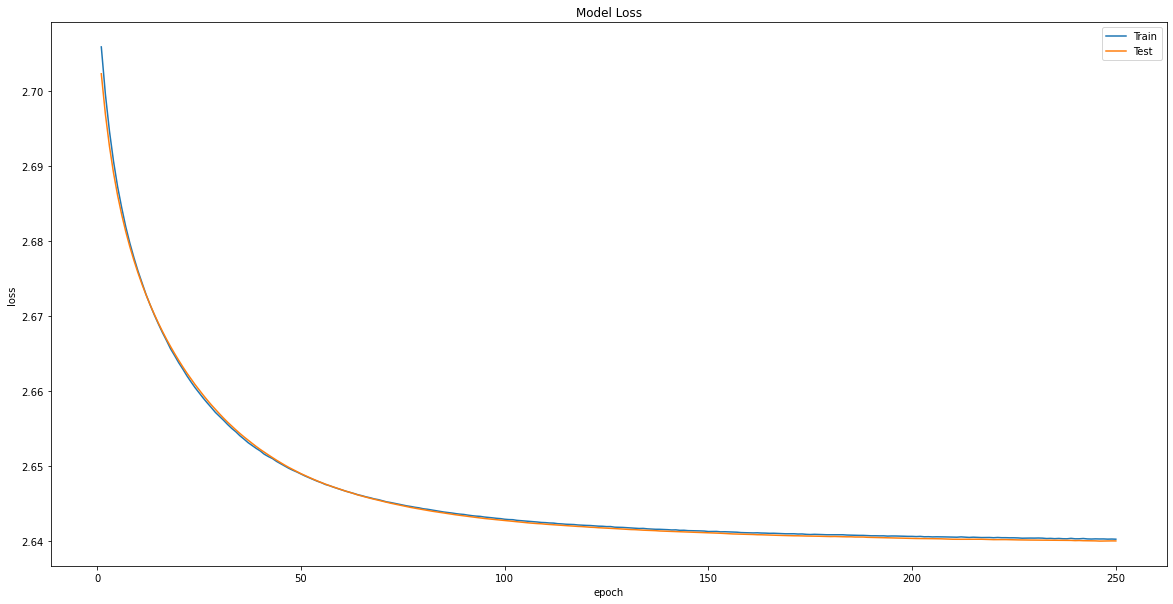

In [101]:
# Save the plot for losses
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_ls) + 1), train_ls, label='Train')
plt.plot(range(1, len(test_ls) + 1), test_ls, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_SGD_qn4_loss_no_dropout.pdf'
)

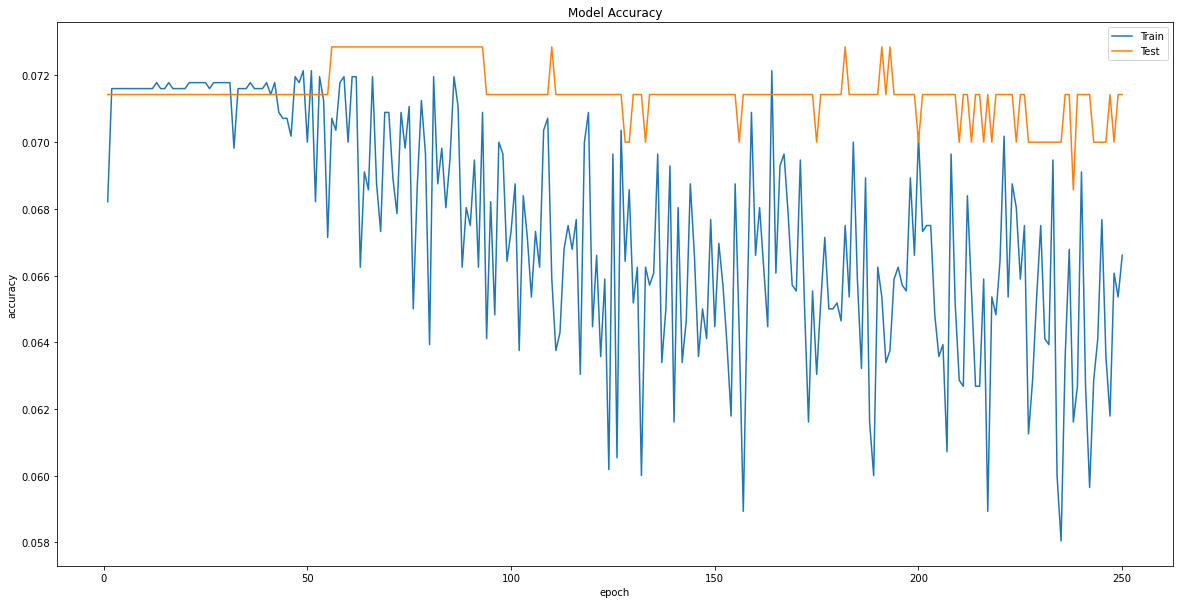

In [102]:
# Save the plot for accuracies
plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.savefig(
    f'./results/partB_SGD_qn4_accuracy_no_dropout.pdf'
)

In [104]:
import csv

with open('run_times.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in run_times.items():
       writer.writerow([key, value])

In [105]:
import pandas as pd

(pd.DataFrame.from_dict(data=run_times, orient='index')
   .to_csv('dict_file.csv', header=False))

In [110]:
with open('run_times.csv') as csv_file:
    reader = csv.reader(csv_file)
    run_times = dict(reader)

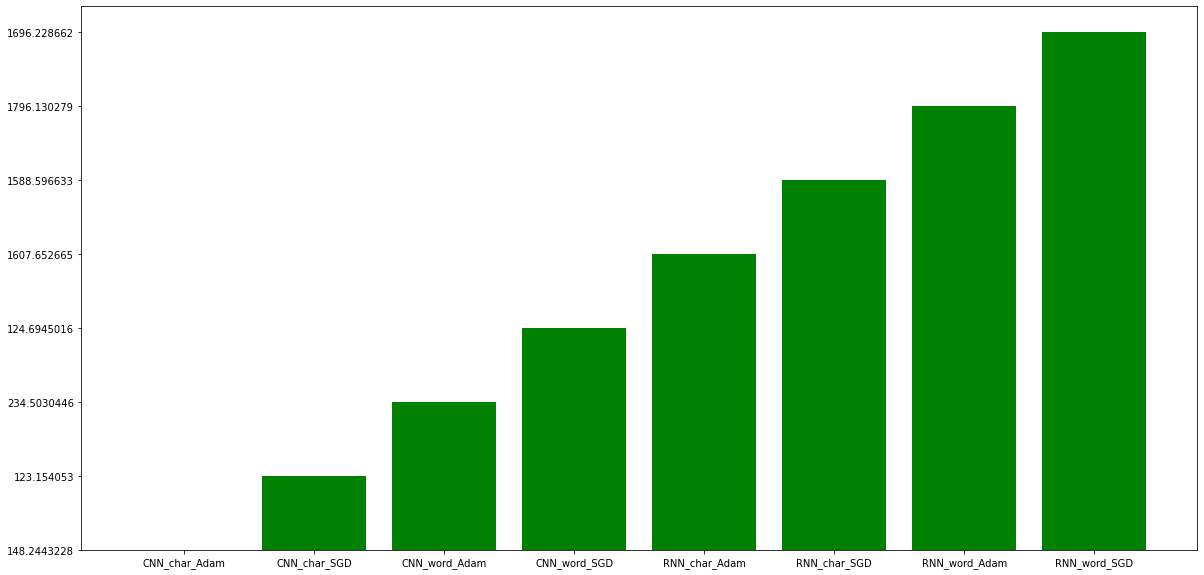

In [113]:
plt.figure(figsize=(20,10))
plt.bar(list(run_times.keys()), run_times.values(), color='g')
plt.savefig(
    f'./results/partB_run_times.pdf'
)

## Question 5

In [117]:
histories = {}

In [118]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import matplotlib.pyplot as plt
import time

MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Build model
tf.keras.backend.set_floatx('float32')

In [119]:
class CharCNN(Model):
    def __init__(self, vocab_size=256):
        super(CharCNN, self).__init__()
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        # forward
        x = tf.one_hot(x, one_hot_size)
        x = x[..., tf.newaxis] 
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

model = CharCNN(256)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.2)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charCNN_Adam_0.2'] = history

Epoch 1, Loss: 2.2136242389678955, Accuracy: 0.24250000715255737, Test Loss: 1.6064834594726562, Test Accuracy: 0.44285714626312256
Epoch 2, Loss: 1.3513201475143433, Accuracy: 0.5260714292526245, Test Loss: 1.1314610242843628, Test Accuracy: 0.6214285492897034
Epoch 3, Loss: 0.9545704126358032, Accuracy: 0.675178587436676, Test Loss: 1.0372295379638672, Test Accuracy: 0.6499999761581421
Epoch 4, Loss: 0.7561458945274353, Accuracy: 0.741428554058075, Test Loss: 1.0944982767105103, Test Accuracy: 0.6571428775787354
Epoch 5, Loss: 0.6191157102584839, Accuracy: 0.7803571224212646, Test Loss: 1.0486966371536255, Test Accuracy: 0.654285728931427
Epoch 6, Loss: 0.5086055397987366, Accuracy: 0.8239285945892334, Test Loss: 1.1275132894515991, Test Accuracy: 0.6671428680419922
Epoch 7, Loss: 0.4617312550544739, Accuracy: 0.8407142758369446, Test Loss: 1.2188979387283325, Test Accuracy: 0.6700000166893005
Epoch 8, Loss: 0.4084281623363495, Accuracy: 0.8585714101791382, Test Loss: 1.2635320425033

Epoch 64, Loss: 0.13927137851715088, Accuracy: 0.9578571319580078, Test Loss: 3.0024032592773438, Test Accuracy: 0.6742857098579407
Epoch 65, Loss: 0.12051720172166824, Accuracy: 0.9633928537368774, Test Loss: 2.897563934326172, Test Accuracy: 0.6842857003211975
Epoch 66, Loss: 0.13601312041282654, Accuracy: 0.9558928608894348, Test Loss: 2.7027981281280518, Test Accuracy: 0.6814285516738892
Epoch 67, Loss: 0.12857964634895325, Accuracy: 0.9612500071525574, Test Loss: 2.840381383895874, Test Accuracy: 0.6842857003211975
Epoch 68, Loss: 0.1292082667350769, Accuracy: 0.9617857336997986, Test Loss: 2.7327778339385986, Test Accuracy: 0.6728571653366089
Epoch 69, Loss: 0.13421081006526947, Accuracy: 0.9589285850524902, Test Loss: 2.933305501937866, Test Accuracy: 0.6557142734527588
Epoch 70, Loss: 0.10796969383955002, Accuracy: 0.9628571271896362, Test Loss: 2.9062068462371826, Test Accuracy: 0.6728571653366089
Epoch 71, Loss: 0.11882481724023819, Accuracy: 0.9607142806053162, Test Loss: 2.

Epoch 127, Loss: 0.1118999645113945, Accuracy: 0.9714285731315613, Test Loss: 3.5038974285125732, Test Accuracy: 0.6800000071525574
Epoch 128, Loss: 0.11286914348602295, Accuracy: 0.9714285731315613, Test Loss: 3.5654420852661133, Test Accuracy: 0.6714285612106323
Epoch 129, Loss: 0.09554160386323929, Accuracy: 0.975178599357605, Test Loss: 3.5100314617156982, Test Accuracy: 0.6785714030265808
Epoch 130, Loss: 0.09510218352079391, Accuracy: 0.9719642996788025, Test Loss: 3.599382162094116, Test Accuracy: 0.6628571152687073
Epoch 131, Loss: 0.11268913000822067, Accuracy: 0.9700000286102295, Test Loss: 3.625976800918579, Test Accuracy: 0.6657142639160156
Epoch 132, Loss: 0.12600861489772797, Accuracy: 0.9673214554786682, Test Loss: 3.749372720718384, Test Accuracy: 0.6657142639160156
Epoch 133, Loss: 0.14281527698040009, Accuracy: 0.9639285802841187, Test Loss: 3.3947646617889404, Test Accuracy: 0.6757143139839172
Epoch 134, Loss: 0.09786081314086914, Accuracy: 0.9721428751945496, Test L

Epoch 190, Loss: 0.09062483161687851, Accuracy: 0.9807142615318298, Test Loss: 3.9486801624298096, Test Accuracy: 0.677142858505249
Epoch 191, Loss: 0.10911241173744202, Accuracy: 0.9762499928474426, Test Loss: 3.9079322814941406, Test Accuracy: 0.6657142639160156
Epoch 192, Loss: 0.10160253196954727, Accuracy: 0.9764285683631897, Test Loss: 3.747049570083618, Test Accuracy: 0.6800000071525574
Epoch 193, Loss: 0.11117894947528839, Accuracy: 0.9755356907844543, Test Loss: 3.8530681133270264, Test Accuracy: 0.677142858505249
Epoch 194, Loss: 0.0894891768693924, Accuracy: 0.9787499904632568, Test Loss: 3.792501449584961, Test Accuracy: 0.6757143139839172
Epoch 195, Loss: 0.08027105778455734, Accuracy: 0.9807142615318298, Test Loss: 3.747896194458008, Test Accuracy: 0.6757143139839172
Epoch 196, Loss: 0.08253299444913864, Accuracy: 0.9807142615318298, Test Loss: 3.840219736099243, Test Accuracy: 0.6800000071525574
Epoch 197, Loss: 0.06866304576396942, Accuracy: 0.9828571677207947, Test Los

In [120]:
model = CharCNN(256)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charCNN_Adam_0.5'] = history

Epoch 1, Loss: 2.6042025089263916, Accuracy: 0.10660714656114578, Test Loss: 2.4373738765716553, Test Accuracy: 0.1728571355342865
Epoch 2, Loss: 2.345301866531372, Accuracy: 0.18410713970661163, Test Loss: 2.230088949203491, Test Accuracy: 0.2257142812013626
Epoch 3, Loss: 2.1627309322357178, Accuracy: 0.23571428656578064, Test Loss: 2.0939202308654785, Test Accuracy: 0.2571428716182709
Epoch 4, Loss: 2.0434396266937256, Accuracy: 0.2589285671710968, Test Loss: 2.0132014751434326, Test Accuracy: 0.29428571462631226
Epoch 5, Loss: 1.959588885307312, Accuracy: 0.26946428418159485, Test Loss: 2.042475461959839, Test Accuracy: 0.28142857551574707
Epoch 6, Loss: 1.9123599529266357, Accuracy: 0.29178571701049805, Test Loss: 1.9692697525024414, Test Accuracy: 0.29571428894996643
Epoch 7, Loss: 1.8633129596710205, Accuracy: 0.29750001430511475, Test Loss: 1.9771586656570435, Test Accuracy: 0.29571428894996643
Epoch 8, Loss: 1.8409847021102905, Accuracy: 0.3050000071525574, Test Loss: 2.016940

Epoch 64, Loss: 0.6265082955360413, Accuracy: 0.7582142949104309, Test Loss: 2.299346923828125, Test Accuracy: 0.572857141494751
Epoch 65, Loss: 0.6160169839859009, Accuracy: 0.7632142901420593, Test Loss: 2.244502305984497, Test Accuracy: 0.558571457862854
Epoch 66, Loss: 0.6254541277885437, Accuracy: 0.7630357146263123, Test Loss: 2.264028549194336, Test Accuracy: 0.5557143092155457
Epoch 67, Loss: 0.6166768074035645, Accuracy: 0.7542856931686401, Test Loss: 2.3660590648651123, Test Accuracy: 0.5685714483261108
Epoch 68, Loss: 0.5834795236587524, Accuracy: 0.7730357050895691, Test Loss: 2.3744914531707764, Test Accuracy: 0.5614285469055176
Epoch 69, Loss: 0.5995418429374695, Accuracy: 0.7616071701049805, Test Loss: 2.367668390274048, Test Accuracy: 0.5785714387893677
Epoch 70, Loss: 0.6037193536758423, Accuracy: 0.7601785659790039, Test Loss: 2.3800222873687744, Test Accuracy: 0.5685714483261108
Epoch 71, Loss: 0.6345701217651367, Accuracy: 0.7541071176528931, Test Loss: 2.4014358520

Epoch 127, Loss: 0.4826933741569519, Accuracy: 0.8171428442001343, Test Loss: 3.0536279678344727, Test Accuracy: 0.5685714483261108
Epoch 128, Loss: 0.4909682273864746, Accuracy: 0.8157142996788025, Test Loss: 2.937077283859253, Test Accuracy: 0.5714285969734192
Epoch 129, Loss: 0.5117141604423523, Accuracy: 0.8066071271896362, Test Loss: 3.0060551166534424, Test Accuracy: 0.5642856955528259
Epoch 130, Loss: 0.5088423490524292, Accuracy: 0.8137500286102295, Test Loss: 2.991185188293457, Test Accuracy: 0.5742856860160828
Epoch 131, Loss: 0.5067189335823059, Accuracy: 0.8123214244842529, Test Loss: 2.9408681392669678, Test Accuracy: 0.5742856860160828
Epoch 132, Loss: 0.5294288992881775, Accuracy: 0.8064285516738892, Test Loss: 2.986943244934082, Test Accuracy: 0.572857141494751
Epoch 133, Loss: 0.5661760568618774, Accuracy: 0.7939285635948181, Test Loss: 2.8515965938568115, Test Accuracy: 0.5642856955528259
Epoch 134, Loss: 0.5146992206573486, Accuracy: 0.8073214292526245, Test Loss: 2.

Epoch 190, Loss: 0.42925170063972473, Accuracy: 0.8378571271896362, Test Loss: 3.0234830379486084, Test Accuracy: 0.5857142806053162
Epoch 191, Loss: 0.4577811360359192, Accuracy: 0.8266071677207947, Test Loss: 2.880157470703125, Test Accuracy: 0.595714271068573
Epoch 192, Loss: 0.44209346175193787, Accuracy: 0.8335714340209961, Test Loss: 3.0838088989257812, Test Accuracy: 0.5842857360839844
Epoch 193, Loss: 0.46737366914749146, Accuracy: 0.8283928632736206, Test Loss: 3.120826005935669, Test Accuracy: 0.5714285969734192
Epoch 194, Loss: 0.44123128056526184, Accuracy: 0.8324999809265137, Test Loss: 2.9969918727874756, Test Accuracy: 0.5885714292526245
Epoch 195, Loss: 0.4433431923389435, Accuracy: 0.8382142782211304, Test Loss: 3.1699535846710205, Test Accuracy: 0.5657142996788025
Epoch 196, Loss: 0.44107845425605774, Accuracy: 0.8348214030265808, Test Loss: 2.9105730056762695, Test Accuracy: 0.595714271068573
Epoch 197, Loss: 0.44358113408088684, Accuracy: 0.8364285826683044, Test Lo

In [121]:
model = CharCNN(256)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.2)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charCNN_SGD_0.2'] = history

Epoch 1, Loss: 2.7067983150482178, Accuracy: 0.07482142746448517, Test Loss: 2.703293800354004, Test Accuracy: 0.09142857044935226
Epoch 2, Loss: 2.701298475265503, Accuracy: 0.09196428209543228, Test Loss: 2.6988964080810547, Test Accuracy: 0.08857142925262451
Epoch 3, Loss: 2.6955530643463135, Accuracy: 0.10535714030265808, Test Loss: 2.6935770511627197, Test Accuracy: 0.10428571701049805
Epoch 4, Loss: 2.689534902572632, Accuracy: 0.11910714209079742, Test Loss: 2.687739610671997, Test Accuracy: 0.1257142871618271
Epoch 5, Loss: 2.682919502258301, Accuracy: 0.13089285790920258, Test Loss: 2.6815309524536133, Test Accuracy: 0.14571428298950195
Epoch 6, Loss: 2.676502227783203, Accuracy: 0.14374999701976776, Test Loss: 2.6750214099884033, Test Accuracy: 0.16285714507102966
Epoch 7, Loss: 2.6691136360168457, Accuracy: 0.14767856895923615, Test Loss: 2.667970895767212, Test Accuracy: 0.18285714089870453
Epoch 8, Loss: 2.6617300510406494, Accuracy: 0.15839286148548126, Test Loss: 2.66064

Epoch 64, Loss: 1.2554147243499756, Accuracy: 0.5735714435577393, Test Loss: 1.3491264581680298, Test Accuracy: 0.5428571701049805
Epoch 65, Loss: 1.2215402126312256, Accuracy: 0.5882142782211304, Test Loss: 1.35781729221344, Test Accuracy: 0.5600000023841858
Epoch 66, Loss: 1.2240875959396362, Accuracy: 0.5903571248054504, Test Loss: 1.3487850427627563, Test Accuracy: 0.5514285564422607
Epoch 67, Loss: 1.2164027690887451, Accuracy: 0.5862500071525574, Test Loss: 1.3495407104492188, Test Accuracy: 0.5600000023841858
Epoch 68, Loss: 1.18617582321167, Accuracy: 0.5971428751945496, Test Loss: 1.3115214109420776, Test Accuracy: 0.5614285469055176
Epoch 69, Loss: 1.1980990171432495, Accuracy: 0.5994642972946167, Test Loss: 1.336304783821106, Test Accuracy: 0.5628571510314941
Epoch 70, Loss: 1.1829092502593994, Accuracy: 0.5933928489685059, Test Loss: 1.313644528388977, Test Accuracy: 0.5714285969734192
Epoch 71, Loss: 1.167465090751648, Accuracy: 0.6035714149475098, Test Loss: 1.29703009128

Epoch 127, Loss: 0.7518179416656494, Accuracy: 0.7462499737739563, Test Loss: 1.1460713148117065, Test Accuracy: 0.6442857384681702
Epoch 128, Loss: 0.762472927570343, Accuracy: 0.7387499809265137, Test Loss: 1.209777593612671, Test Accuracy: 0.6214285492897034
Epoch 129, Loss: 0.7571739554405212, Accuracy: 0.741607129573822, Test Loss: 1.1064512729644775, Test Accuracy: 0.6385714411735535
Epoch 130, Loss: 0.7548086643218994, Accuracy: 0.7451785802841187, Test Loss: 1.159773349761963, Test Accuracy: 0.6428571343421936
Epoch 131, Loss: 0.7493792176246643, Accuracy: 0.746071457862854, Test Loss: 1.2221935987472534, Test Accuracy: 0.6285714507102966
Epoch 132, Loss: 0.7497537732124329, Accuracy: 0.7437499761581421, Test Loss: 1.1197171211242676, Test Accuracy: 0.645714282989502
Epoch 133, Loss: 0.7721796631813049, Accuracy: 0.7387499809265137, Test Loss: 1.1195529699325562, Test Accuracy: 0.6499999761581421
Epoch 134, Loss: 0.7194216251373291, Accuracy: 0.7549999952316284, Test Loss: 1.13

Epoch 190, Loss: 0.5305821895599365, Accuracy: 0.8216071724891663, Test Loss: 1.1665118932724, Test Accuracy: 0.6499999761581421
Epoch 191, Loss: 0.5446028709411621, Accuracy: 0.8137500286102295, Test Loss: 1.2435249090194702, Test Accuracy: 0.6328571438789368
Epoch 192, Loss: 0.5532434582710266, Accuracy: 0.8121428489685059, Test Loss: 1.1307423114776611, Test Accuracy: 0.6785714030265808
Epoch 193, Loss: 0.5879649519920349, Accuracy: 0.801964282989502, Test Loss: 1.1167572736740112, Test Accuracy: 0.6614285707473755
Epoch 194, Loss: 0.5650827884674072, Accuracy: 0.8073214292526245, Test Loss: 1.141373634338379, Test Accuracy: 0.6628571152687073
Epoch 195, Loss: 0.5373579263687134, Accuracy: 0.8174999952316284, Test Loss: 1.1095954179763794, Test Accuracy: 0.6700000166893005
Epoch 196, Loss: 0.5420241951942444, Accuracy: 0.8153571486473083, Test Loss: 1.170399785041809, Test Accuracy: 0.668571412563324
Epoch 197, Loss: 0.527775228023529, Accuracy: 0.8196428418159485, Test Loss: 1.1235

In [122]:
model = CharCNN(256)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charCNN_SGD_0.5'] = history

Epoch 1, Loss: 2.703212022781372, Accuracy: 0.07678571343421936, Test Loss: 2.6972100734710693, Test Accuracy: 0.07571428269147873
Epoch 2, Loss: 2.6967334747314453, Accuracy: 0.07732142508029938, Test Loss: 2.6914989948272705, Test Accuracy: 0.07428571581840515
Epoch 3, Loss: 2.6899149417877197, Accuracy: 0.08571428805589676, Test Loss: 2.685643196105957, Test Accuracy: 0.0771428570151329
Epoch 4, Loss: 2.6831326484680176, Accuracy: 0.09000000357627869, Test Loss: 2.6799514293670654, Test Accuracy: 0.07428571581840515
Epoch 5, Loss: 2.678964853286743, Accuracy: 0.09410714358091354, Test Loss: 2.674603223800659, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.674090623855591, Accuracy: 0.09482143074274063, Test Loss: 2.6689350605010986, Test Accuracy: 0.0771428570151329
Epoch 7, Loss: 2.6632068157196045, Accuracy: 0.10339285433292389, Test Loss: 2.6621663570404053, Test Accuracy: 0.08714285492897034
Epoch 8, Loss: 2.6599600315093994, Accuracy: 0.10607142746448517, Test Loss: 2.65612

Epoch 64, Loss: 1.471360445022583, Accuracy: 0.5071428418159485, Test Loss: 1.4195904731750488, Test Accuracy: 0.5514285564422607
Epoch 65, Loss: 1.4505865573883057, Accuracy: 0.5199999809265137, Test Loss: 1.4330123662948608, Test Accuracy: 0.5557143092155457
Epoch 66, Loss: 1.4364176988601685, Accuracy: 0.5074999928474426, Test Loss: 1.3910231590270996, Test Accuracy: 0.558571457862854
Epoch 67, Loss: 1.4172831773757935, Accuracy: 0.5210714340209961, Test Loss: 1.3733841180801392, Test Accuracy: 0.5514285564422607
Epoch 68, Loss: 1.406820297241211, Accuracy: 0.5235714316368103, Test Loss: 1.3714998960494995, Test Accuracy: 0.5571428537368774
Epoch 69, Loss: 1.3830480575561523, Accuracy: 0.535178542137146, Test Loss: 1.35124671459198, Test Accuracy: 0.5642856955528259
Epoch 70, Loss: 1.376876950263977, Accuracy: 0.5285714268684387, Test Loss: 1.3336857557296753, Test Accuracy: 0.5600000023841858
Epoch 71, Loss: 1.3577991724014282, Accuracy: 0.5405356884002686, Test Loss: 1.35228621959

Epoch 127, Loss: 0.8704920411109924, Accuracy: 0.708392858505249, Test Loss: 1.0239351987838745, Test Accuracy: 0.677142858505249
Epoch 128, Loss: 0.874289870262146, Accuracy: 0.708214282989502, Test Loss: 1.0390872955322266, Test Accuracy: 0.6671428680419922
Epoch 129, Loss: 0.8642258048057556, Accuracy: 0.7028571367263794, Test Loss: 0.9968805909156799, Test Accuracy: 0.6728571653366089
Epoch 130, Loss: 0.855143129825592, Accuracy: 0.706428587436676, Test Loss: 1.0432590246200562, Test Accuracy: 0.6671428680419922
Epoch 131, Loss: 0.8425413370132446, Accuracy: 0.7142857313156128, Test Loss: 1.0419892072677612, Test Accuracy: 0.6671428680419922
Epoch 132, Loss: 0.8446788787841797, Accuracy: 0.7121428847312927, Test Loss: 0.9982835650444031, Test Accuracy: 0.6742857098579407
Epoch 133, Loss: 0.8448793292045593, Accuracy: 0.710357129573822, Test Loss: 1.0084131956100464, Test Accuracy: 0.6757143139839172
Epoch 134, Loss: 0.8243980407714844, Accuracy: 0.7262499928474426, Test Loss: 1.008

Epoch 190, Loss: 0.6189612746238708, Accuracy: 0.7891071438789368, Test Loss: 1.0233265161514282, Test Accuracy: 0.6814285516738892
Epoch 191, Loss: 0.6291690468788147, Accuracy: 0.789642870426178, Test Loss: 0.9681393504142761, Test Accuracy: 0.6985714435577393
Epoch 192, Loss: 0.6395611763000488, Accuracy: 0.7858928442001343, Test Loss: 1.0099992752075195, Test Accuracy: 0.6857143044471741
Epoch 193, Loss: 0.6373440623283386, Accuracy: 0.7823214530944824, Test Loss: 1.0147565603256226, Test Accuracy: 0.6871428489685059
Epoch 194, Loss: 0.6438168883323669, Accuracy: 0.7833928465843201, Test Loss: 0.9824163913726807, Test Accuracy: 0.6899999976158142
Epoch 195, Loss: 0.611566960811615, Accuracy: 0.7883928418159485, Test Loss: 0.9844337105751038, Test Accuracy: 0.6971428394317627
Epoch 196, Loss: 0.6401016712188721, Accuracy: 0.7805356979370117, Test Loss: 0.9540436267852783, Test Accuracy: 0.699999988079071
Epoch 197, Loss: 0.6348771452903748, Accuracy: 0.7837499976158142, Test Loss: 0

In [123]:
histories

{'charCNN_Adam_0.2': {'train_acc': [<tf.Tensor: shape=(), dtype=float32, numpy=0.2425>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.5260714>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.6751786>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.74142855>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.7803571>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.8239286>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.8407143>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.8585714>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.8669643>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.87535715>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.89>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.9028571>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.9103571>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.90589285>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.9176786>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.9244643>,
   <tf.Tensor: shape=(), dtype=float32, nump

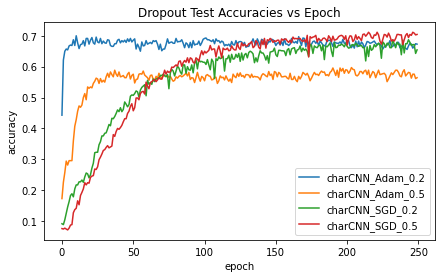

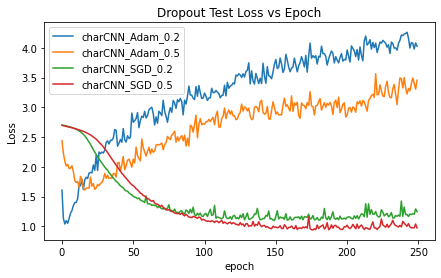

In [129]:
plt.figure(figsize=(7,4))
plt.plot(histories['charCNN_Adam_0.2']['test_acc'])
plt.plot(histories['charCNN_Adam_0.5']['test_acc'])
plt.plot(histories['charCNN_SGD_0.2']['test_acc'])
plt.plot(histories['charCNN_SGD_0.5']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['charCNN_Adam_0.2','charCNN_Adam_0.5','charCNN_SGD_0.2','charCNN_SGD_0.5'], loc='lower right')

plt.savefig(
    f'./results/partB_qn5_charCNN_dropout_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['charCNN_Adam_0.2']['test_loss'])
plt.plot(histories['charCNN_Adam_0.5']['test_loss'])
plt.plot(histories['charCNN_SGD_0.2']['test_loss'])
plt.plot(histories['charCNN_SGD_0.5']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['charCNN_Adam_0.2','charCNN_Adam_0.5','charCNN_SGD_0.2','charCNN_SGD_0.5'], loc='upper left')

plt.savefig(
    f'./results/partB_qn5_charCNN_dropout_loss.pdf'
)

In [130]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import nltk

nltk.download('punkt')

MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
EMBEDDING_SIZE = 20
FILTER_SHAPE1 = [20, 20]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)


def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text


def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict


def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x


def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size


x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[nltk_data] Downloading package punkt to C:\Users\Shearman
[nltk_data]     Chua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [131]:
# Build model
tf.keras.backend.set_floatx('float32')

class WordCNN(Model):
    def __init__(self, vocab_size=256):
        super(WordCNN, self).__init__()
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        self.reshape = layers.Reshape((MAX_DOCUMENT_LENGTH, EMBEDDING_SIZE, 1))
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        # forward
        x = self.embedding(x)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

model = WordCNN(vocab_size)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.2)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordCNN_Adam_0.2'] = history

Epoch 1, Loss: 2.260565996170044, Accuracy: 0.18928571045398712, Test Loss: 1.6029261350631714, Test Accuracy: 0.41857144236564636
Epoch 2, Loss: 1.2248114347457886, Accuracy: 0.5489285588264465, Test Loss: 0.9670944809913635, Test Accuracy: 0.6957142949104309
Epoch 3, Loss: 0.5100863575935364, Accuracy: 0.8258928656578064, Test Loss: 0.7171938419342041, Test Accuracy: 0.7857142686843872
Epoch 4, Loss: 0.2476271539926529, Accuracy: 0.9223214387893677, Test Loss: 0.6623572707176208, Test Accuracy: 0.8071428537368774
Epoch 5, Loss: 0.12729014456272125, Accuracy: 0.9585714340209961, Test Loss: 0.7107132077217102, Test Accuracy: 0.8399999737739563
Epoch 6, Loss: 0.07547114789485931, Accuracy: 0.9783928394317627, Test Loss: 0.7947137951850891, Test Accuracy: 0.8214285969734192
Epoch 7, Loss: 0.07595031708478928, Accuracy: 0.9796428680419922, Test Loss: 0.8091285228729248, Test Accuracy: 0.8385714292526245
Epoch 8, Loss: 0.0679904967546463, Accuracy: 0.981249988079071, Test Loss: 1.006705641

Epoch 64, Loss: 0.6137651205062866, Accuracy: 0.9589285850524902, Test Loss: 2.2192935943603516, Test Accuracy: 0.8371428847312927
Epoch 65, Loss: 0.5391467213630676, Accuracy: 0.9642857313156128, Test Loss: 2.456014394760132, Test Accuracy: 0.8299999833106995
Epoch 66, Loss: 0.47812163829803467, Accuracy: 0.9674999713897705, Test Loss: 2.5031063556671143, Test Accuracy: 0.831428587436676
Epoch 67, Loss: 0.43461787700653076, Accuracy: 0.9714285731315613, Test Loss: 2.2283811569213867, Test Accuracy: 0.8485714197158813
Epoch 68, Loss: 0.4426029920578003, Accuracy: 0.970714271068573, Test Loss: 2.567275047302246, Test Accuracy: 0.8257142901420593
Epoch 69, Loss: 0.35830000042915344, Accuracy: 0.9757142663002014, Test Loss: 2.16489839553833, Test Accuracy: 0.8414285778999329
Epoch 70, Loss: 0.5588706731796265, Accuracy: 0.9635714292526245, Test Loss: 2.0806918144226074, Test Accuracy: 0.8485714197158813
Epoch 71, Loss: 0.5707545876502991, Accuracy: 0.9626785516738892, Test Loss: 2.3329708

Epoch 127, Loss: 1.1775410175323486, Accuracy: 0.9246428608894348, Test Loss: 3.044067621231079, Test Accuracy: 0.7985714077949524
Epoch 128, Loss: 0.9374357461929321, Accuracy: 0.9405357241630554, Test Loss: 2.39475417137146, Test Accuracy: 0.8357142806053162
Epoch 129, Loss: 0.9403207302093506, Accuracy: 0.9396428465843201, Test Loss: 2.607612371444702, Test Accuracy: 0.8214285969734192
Epoch 130, Loss: 0.7314196228981018, Accuracy: 0.9539285898208618, Test Loss: 3.0493202209472656, Test Accuracy: 0.8014285564422607
Epoch 131, Loss: 1.0685206651687622, Accuracy: 0.9323214292526245, Test Loss: 2.978070020675659, Test Accuracy: 0.800000011920929
Epoch 132, Loss: 0.938352644443512, Accuracy: 0.9407142996788025, Test Loss: 2.849489450454712, Test Accuracy: 0.8057143092155457
Epoch 133, Loss: 0.7889947891235352, Accuracy: 0.9496428370475769, Test Loss: 2.81976580619812, Test Accuracy: 0.808571457862854
Epoch 134, Loss: 0.7026369571685791, Accuracy: 0.9546428322792053, Test Loss: 2.7578477

Epoch 190, Loss: 0.8516180515289307, Accuracy: 0.9451785683631897, Test Loss: 2.587693452835083, Test Accuracy: 0.8271428346633911
Epoch 191, Loss: 0.7983441948890686, Accuracy: 0.9491071701049805, Test Loss: 2.6097443103790283, Test Accuracy: 0.8242856860160828
Epoch 192, Loss: 0.7344226241111755, Accuracy: 0.9528571367263794, Test Loss: 2.2515623569488525, Test Accuracy: 0.8485714197158813
Epoch 193, Loss: 0.6523494720458984, Accuracy: 0.9574999809265137, Test Loss: 2.647088050842285, Test Accuracy: 0.8257142901420593
Epoch 194, Loss: 0.6742215752601624, Accuracy: 0.9569643139839172, Test Loss: 2.2934048175811768, Test Accuracy: 0.8485714197158813
Epoch 195, Loss: 0.5406757593154907, Accuracy: 0.9649999737739563, Test Loss: 2.117748737335205, Test Accuracy: 0.8585714101791382
Epoch 196, Loss: 0.49590644240379333, Accuracy: 0.9683928489685059, Test Loss: 2.112389326095581, Test Accuracy: 0.8585714101791382
Epoch 197, Loss: 0.5720562934875488, Accuracy: 0.9637500047683716, Test Loss: 2

In [132]:
model = WordCNN(vocab_size)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordCNN_Adam_0.5'] = history

Epoch 1, Loss: 2.3796472549438477, Accuracy: 0.15660713613033295, Test Loss: 1.8057013750076294, Test Accuracy: 0.2985714375972748
Epoch 2, Loss: 1.5098342895507812, Accuracy: 0.43464285135269165, Test Loss: 1.1326574087142944, Test Accuracy: 0.6071428656578064
Epoch 3, Loss: 0.9795879125595093, Accuracy: 0.6412500143051147, Test Loss: 0.932248592376709, Test Accuracy: 0.6757143139839172
Epoch 4, Loss: 0.7374253869056702, Accuracy: 0.7403571605682373, Test Loss: 0.8658652305603027, Test Accuracy: 0.7528571486473083
Epoch 5, Loss: 0.568156898021698, Accuracy: 0.8051785826683044, Test Loss: 0.8847789764404297, Test Accuracy: 0.7442857027053833
Epoch 6, Loss: 0.4544405937194824, Accuracy: 0.8473214507102966, Test Loss: 0.8905725479125977, Test Accuracy: 0.7457143068313599
Epoch 7, Loss: 0.38625195622444153, Accuracy: 0.876964271068573, Test Loss: 0.9041855335235596, Test Accuracy: 0.7642857432365417
Epoch 8, Loss: 0.32829898595809937, Accuracy: 0.8951785564422607, Test Loss: 1.05112087726

Epoch 64, Loss: 0.6969958543777466, Accuracy: 0.9275000095367432, Test Loss: 2.886744260787964, Test Accuracy: 0.7714285850524902
Epoch 65, Loss: 1.0671683549880981, Accuracy: 0.9033928513526917, Test Loss: 2.627500057220459, Test Accuracy: 0.7942857146263123
Epoch 66, Loss: 0.928312361240387, Accuracy: 0.902321457862854, Test Loss: 2.5389716625213623, Test Accuracy: 0.7771428823471069
Epoch 67, Loss: 0.9931825995445251, Accuracy: 0.8876785635948181, Test Loss: 2.2596094608306885, Test Accuracy: 0.7942857146263123
Epoch 68, Loss: 0.785343587398529, Accuracy: 0.9012500047683716, Test Loss: 2.2773289680480957, Test Accuracy: 0.7799999713897705
Epoch 69, Loss: 0.8952839374542236, Accuracy: 0.8883928656578064, Test Loss: 2.348747968673706, Test Accuracy: 0.7885714173316956
Epoch 70, Loss: 0.6716040968894958, Accuracy: 0.9105356931686401, Test Loss: 2.557533025741577, Test Accuracy: 0.7742857336997986
Epoch 71, Loss: 0.7211448550224304, Accuracy: 0.9178571701049805, Test Loss: 2.43756413459

Epoch 127, Loss: 1.0918105840682983, Accuracy: 0.9067857265472412, Test Loss: 2.957366943359375, Test Accuracy: 0.7871428728103638
Epoch 128, Loss: 0.8869131207466125, Accuracy: 0.9228571653366089, Test Loss: 2.61767840385437, Test Accuracy: 0.8171428442001343
Epoch 129, Loss: 0.9652202725410461, Accuracy: 0.9221428632736206, Test Loss: 2.9712235927581787, Test Accuracy: 0.7871428728103638
Epoch 130, Loss: 0.9601697325706482, Accuracy: 0.920714259147644, Test Loss: 2.7419068813323975, Test Accuracy: 0.8057143092155457
Epoch 131, Loss: 0.821316123008728, Accuracy: 0.9301785826683044, Test Loss: 2.442025899887085, Test Accuracy: 0.8199999928474426
Epoch 132, Loss: 0.7189970016479492, Accuracy: 0.9366071224212646, Test Loss: 2.7058002948760986, Test Accuracy: 0.8014285564422607
Epoch 133, Loss: 0.791163444519043, Accuracy: 0.9330357313156128, Test Loss: 2.4963035583496094, Test Accuracy: 0.8142856955528259
Epoch 134, Loss: 0.863974392414093, Accuracy: 0.9242857098579407, Test Loss: 2.4374

Epoch 190, Loss: 1.1238136291503906, Accuracy: 0.9117857217788696, Test Loss: 3.1580655574798584, Test Accuracy: 0.7771428823471069
Epoch 191, Loss: 1.2728146314620972, Accuracy: 0.9041071534156799, Test Loss: 2.8505773544311523, Test Accuracy: 0.8014285564422607
Epoch 192, Loss: 0.906450629234314, Accuracy: 0.928928554058075, Test Loss: 2.694880723953247, Test Accuracy: 0.8057143092155457
Epoch 193, Loss: 0.979680061340332, Accuracy: 0.9233928322792053, Test Loss: 2.562318801879883, Test Accuracy: 0.8142856955528259
Epoch 194, Loss: 1.0288957357406616, Accuracy: 0.9208928346633911, Test Loss: 2.7426397800445557, Test Accuracy: 0.808571457862854
Epoch 195, Loss: 0.9665367007255554, Accuracy: 0.9278571605682373, Test Loss: 2.8241994380950928, Test Accuracy: 0.8042857050895691
Epoch 196, Loss: 0.9913058876991272, Accuracy: 0.9248214364051819, Test Loss: 3.297419309616089, Test Accuracy: 0.7757142782211304
Epoch 197, Loss: 1.1451172828674316, Accuracy: 0.9133928418159485, Test Loss: 3.331

In [133]:
model = WordCNN(vocab_size)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.2)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordCNN_SGD_0.2'] = history

Epoch 1, Loss: 2.70381760597229, Accuracy: 0.07053571194410324, Test Loss: 2.700998306274414, Test Accuracy: 0.0771428570151329
Epoch 2, Loss: 2.700073480606079, Accuracy: 0.07535714656114578, Test Loss: 2.6974010467529297, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.697751522064209, Accuracy: 0.07285714149475098, Test Loss: 2.694502592086792, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.6940038204193115, Accuracy: 0.07607142627239227, Test Loss: 2.691610336303711, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.6907804012298584, Accuracy: 0.06875000149011612, Test Loss: 2.68884015083313, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.6894941329956055, Accuracy: 0.0701785683631897, Test Loss: 2.68644642829895, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.6884043216705322, Accuracy: 0.06892856955528259, Test Loss: 2.684372901916504, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.6859567165374756, Accuracy: 0.0746428593993187, Test Loss: 2.682276725769043, T

Epoch 64, Loss: 2.6300277709960938, Accuracy: 0.09857142716646194, Test Loss: 2.615891933441162, Test Accuracy: 0.11428571492433548
Epoch 65, Loss: 2.6248724460601807, Accuracy: 0.09892857074737549, Test Loss: 2.6140716075897217, Test Accuracy: 0.11142857372760773
Epoch 66, Loss: 2.622943639755249, Accuracy: 0.09857142716646194, Test Loss: 2.6122004985809326, Test Accuracy: 0.1071428582072258
Epoch 67, Loss: 2.6221694946289062, Accuracy: 0.1058928593993187, Test Loss: 2.6110923290252686, Test Accuracy: 0.10999999940395355
Epoch 68, Loss: 2.62221622467041, Accuracy: 0.1007142886519432, Test Loss: 2.6098639965057373, Test Accuracy: 0.11571428924798965
Epoch 69, Loss: 2.6210684776306152, Accuracy: 0.10303571075201035, Test Loss: 2.6083009243011475, Test Accuracy: 0.1128571406006813
Epoch 70, Loss: 2.620037794113159, Accuracy: 0.10535714030265808, Test Loss: 2.6071054935455322, Test Accuracy: 0.11571428924798965
Epoch 71, Loss: 2.6145200729370117, Accuracy: 0.1116071417927742, Test Loss: 2

Epoch 127, Loss: 2.585867166519165, Accuracy: 0.11785714328289032, Test Loss: 2.573484182357788, Test Accuracy: 0.12142857164144516
Epoch 128, Loss: 2.587944746017456, Accuracy: 0.11749999970197678, Test Loss: 2.573397397994995, Test Accuracy: 0.11571428924798965
Epoch 129, Loss: 2.5884532928466797, Accuracy: 0.11303571611642838, Test Loss: 2.572927713394165, Test Accuracy: 0.10999999940395355
Epoch 130, Loss: 2.585029363632202, Accuracy: 0.11892857402563095, Test Loss: 2.572309970855713, Test Accuracy: 0.10999999940395355
Epoch 131, Loss: 2.581186056137085, Accuracy: 0.1192857176065445, Test Loss: 2.5712201595306396, Test Accuracy: 0.11428571492433548
Epoch 132, Loss: 2.5828895568847656, Accuracy: 0.11660714447498322, Test Loss: 2.5705454349517822, Test Accuracy: 0.11142857372760773
Epoch 133, Loss: 2.584749937057495, Accuracy: 0.11857143044471741, Test Loss: 2.569700241088867, Test Accuracy: 0.12428571283817291
Epoch 134, Loss: 2.5806760787963867, Accuracy: 0.12428571283817291, Test 

Epoch 189, Loss: 2.3008949756622314, Accuracy: 0.22303570806980133, Test Loss: 2.268918991088867, Test Accuracy: 0.22857142984867096
Epoch 190, Loss: 2.28194260597229, Accuracy: 0.22732143104076385, Test Loss: 2.2411489486694336, Test Accuracy: 0.2314285784959793
Epoch 191, Loss: 2.2612833976745605, Accuracy: 0.23125000298023224, Test Loss: 2.2825591564178467, Test Accuracy: 0.21285714209079742
Epoch 192, Loss: 2.2515757083892822, Accuracy: 0.23392857611179352, Test Loss: 2.2041127681732178, Test Accuracy: 0.2442857176065445
Epoch 193, Loss: 2.2359249591827393, Accuracy: 0.23160713911056519, Test Loss: 2.195601463317871, Test Accuracy: 0.238571435213089
Epoch 194, Loss: 2.2064268589019775, Accuracy: 0.24250000715255737, Test Loss: 2.150644302368164, Test Accuracy: 0.261428564786911
Epoch 195, Loss: 2.1830129623413086, Accuracy: 0.2462500035762787, Test Loss: 2.1448864936828613, Test Accuracy: 0.27000001072883606
Epoch 196, Loss: 2.1649985313415527, Accuracy: 0.25803571939468384, Test L

In [134]:
model = WordCNN(vocab_size)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordCNN_SGD_0.5'] = history

Epoch 1, Loss: 2.7058887481689453, Accuracy: 0.07178571075201035, Test Loss: 2.7037298679351807, Test Accuracy: 0.07285714149475098
Epoch 2, Loss: 2.701411485671997, Accuracy: 0.07160714268684387, Test Loss: 2.699869394302368, Test Accuracy: 0.06285714358091354
Epoch 3, Loss: 2.698127508163452, Accuracy: 0.0714285746216774, Test Loss: 2.696830987930298, Test Accuracy: 0.06285714358091354
Epoch 4, Loss: 2.6961965560913086, Accuracy: 0.07696428894996643, Test Loss: 2.6943423748016357, Test Accuracy: 0.06857142597436905
Epoch 5, Loss: 2.692896842956543, Accuracy: 0.0726785734295845, Test Loss: 2.6919984817504883, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.6916728019714355, Accuracy: 0.06910714507102966, Test Loss: 2.689821243286133, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.6908037662506104, Accuracy: 0.06857142597436905, Test Loss: 2.6880950927734375, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.688988447189331, Accuracy: 0.07035714387893677, Test Loss: 2.686403512

Epoch 64, Loss: 2.6487481594085693, Accuracy: 0.07857143133878708, Test Loss: 2.642982244491577, Test Accuracy: 0.08285713940858841
Epoch 65, Loss: 2.650082588195801, Accuracy: 0.08232142776250839, Test Loss: 2.6423187255859375, Test Accuracy: 0.08428571373224258
Epoch 66, Loss: 2.650576591491699, Accuracy: 0.0816071406006813, Test Loss: 2.6417148113250732, Test Accuracy: 0.09142857044935226
Epoch 67, Loss: 2.6491944789886475, Accuracy: 0.08214285969734192, Test Loss: 2.6410305500030518, Test Accuracy: 0.09571428596973419
Epoch 68, Loss: 2.6470632553100586, Accuracy: 0.08535714447498322, Test Loss: 2.640241861343384, Test Accuracy: 0.09428571164608002
Epoch 69, Loss: 2.6497156620025635, Accuracy: 0.08053571730852127, Test Loss: 2.639965057373047, Test Accuracy: 0.09714286029338837
Epoch 70, Loss: 2.6432456970214844, Accuracy: 0.08446428924798965, Test Loss: 2.6383776664733887, Test Accuracy: 0.09285714477300644
Epoch 71, Loss: 2.6445183753967285, Accuracy: 0.08964285999536514, Test Los

Epoch 126, Loss: 2.6068379878997803, Accuracy: 0.09714286029338837, Test Loss: 2.590317964553833, Test Accuracy: 0.11142857372760773
Epoch 127, Loss: 2.606600046157837, Accuracy: 0.09767857193946838, Test Loss: 2.589182138442993, Test Accuracy: 0.11142857372760773
Epoch 128, Loss: 2.605388879776001, Accuracy: 0.10750000178813934, Test Loss: 2.5879414081573486, Test Accuracy: 0.10857142508029938
Epoch 129, Loss: 2.6097638607025146, Accuracy: 0.10000000149011612, Test Loss: 2.5874738693237305, Test Accuracy: 0.11571428924798965
Epoch 130, Loss: 2.606217622756958, Accuracy: 0.10374999791383743, Test Loss: 2.586470365524292, Test Accuracy: 0.10999999940395355
Epoch 131, Loss: 2.600980043411255, Accuracy: 0.10571428388357162, Test Loss: 2.5850212574005127, Test Accuracy: 0.11142857372760773
Epoch 132, Loss: 2.6004762649536133, Accuracy: 0.10553571581840515, Test Loss: 2.58333420753479, Test Accuracy: 0.11428571492433548
Epoch 133, Loss: 2.597829818725586, Accuracy: 0.11124999821186066, Test

Epoch 188, Loss: 2.1869089603424072, Accuracy: 0.20446428656578064, Test Loss: 2.1308677196502686, Test Accuracy: 0.2514285743236542
Epoch 189, Loss: 2.182147264480591, Accuracy: 0.20678570866584778, Test Loss: 2.1224989891052246, Test Accuracy: 0.24857142567634583
Epoch 190, Loss: 2.175339698791504, Accuracy: 0.20589286088943481, Test Loss: 2.117438316345215, Test Accuracy: 0.25857141613960266
Epoch 191, Loss: 2.16306209564209, Accuracy: 0.20946428179740906, Test Loss: 2.1014957427978516, Test Accuracy: 0.25857141613960266
Epoch 192, Loss: 2.155961751937866, Accuracy: 0.21214285492897034, Test Loss: 2.0939900875091553, Test Accuracy: 0.2685714364051819
Epoch 193, Loss: 2.1441712379455566, Accuracy: 0.207857146859169, Test Loss: 2.0816380977630615, Test Accuracy: 0.25999999046325684
Epoch 194, Loss: 2.1328134536743164, Accuracy: 0.2135714292526245, Test Loss: 2.073490858078003, Test Accuracy: 0.27000001072883606
Epoch 195, Loss: 2.11295485496521, Accuracy: 0.2219642847776413, Test Loss

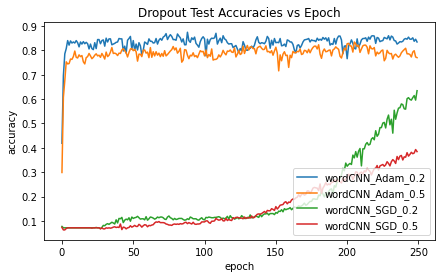

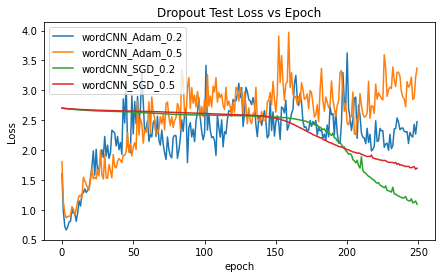

In [135]:
plt.figure(figsize=(7,4))
plt.plot(histories['wordCNN_Adam_0.2']['test_acc'])
plt.plot(histories['wordCNN_Adam_0.5']['test_acc'])
plt.plot(histories['wordCNN_SGD_0.2']['test_acc'])
plt.plot(histories['wordCNN_SGD_0.5']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['wordCNN_Adam_0.2','wordCNN_Adam_0.5','wordCNN_SGD_0.2','wordCNN_SGD_0.5'], loc='lower right')

plt.savefig(
    f'./results/partB_qn5_wordCNN_dropout_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['wordCNN_Adam_0.2']['test_loss'])
plt.plot(histories['wordCNN_Adam_0.5']['test_loss'])
plt.plot(histories['wordCNN_SGD_0.2']['test_loss'])
plt.plot(histories['wordCNN_SGD_0.5']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['wordCNN_Adam_0.2','wordCNN_Adam_0.5','wordCNN_SGD_0.2','wordCNN_SGD_0.5'], loc='upper left')

plt.savefig(
    f'./results/partB_qn5_wordCNN_dropout_loss.pdf'
)

In [136]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import matplotlib.pyplot as plt
import time

MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE = 20
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [137]:
# Build model
tf.keras.backend.set_floatx('float32')

class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.2)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_Adam_0.2'] = history

Epoch 1, Loss: 2.654085159301758, Accuracy: 0.08285713940858841, Test Loss: 2.5989530086517334, Test Accuracy: 0.10571428388357162
Epoch 2, Loss: 2.548462152481079, Accuracy: 0.12607142329216003, Test Loss: 2.455681562423706, Test Accuracy: 0.1371428519487381
Epoch 3, Loss: 2.3292582035064697, Accuracy: 0.18089285492897034, Test Loss: 2.222867012023926, Test Accuracy: 0.2085714340209961
Epoch 4, Loss: 2.135575294494629, Accuracy: 0.24589285254478455, Test Loss: 2.0407726764678955, Test Accuracy: 0.2971428632736206
Epoch 5, Loss: 1.8576778173446655, Accuracy: 0.34339284896850586, Test Loss: 1.8386510610580444, Test Accuracy: 0.35857143998146057
Epoch 6, Loss: 1.6819621324539185, Accuracy: 0.41232141852378845, Test Loss: 1.6663264036178589, Test Accuracy: 0.4099999964237213
Epoch 7, Loss: 1.5303940773010254, Accuracy: 0.4507142901420593, Test Loss: 1.5358041524887085, Test Accuracy: 0.4528571367263794
Epoch 8, Loss: 1.4197009801864624, Accuracy: 0.4950000047683716, Test Loss: 1.533001065

Epoch 64, Loss: 0.5039322376251221, Accuracy: 0.8321428298950195, Test Loss: 1.1194539070129395, Test Accuracy: 0.7057142853736877
Epoch 65, Loss: 0.5011764168739319, Accuracy: 0.8366071581840515, Test Loss: 1.194158673286438, Test Accuracy: 0.6971428394317627
Epoch 66, Loss: 0.5036781430244446, Accuracy: 0.8319643139839172, Test Loss: 1.1825532913208008, Test Accuracy: 0.6971428394317627
Epoch 67, Loss: 0.5475728511810303, Accuracy: 0.8151785731315613, Test Loss: 1.1232203245162964, Test Accuracy: 0.7057142853736877
Epoch 68, Loss: 0.5025657415390015, Accuracy: 0.8337500095367432, Test Loss: 1.1337568759918213, Test Accuracy: 0.7157142758369446
Epoch 69, Loss: 0.5036200881004333, Accuracy: 0.8317857384681702, Test Loss: 1.2227703332901, Test Accuracy: 0.6928571462631226
Epoch 70, Loss: 0.5053931474685669, Accuracy: 0.8344643115997314, Test Loss: 1.1342862844467163, Test Accuracy: 0.7085714340209961
Epoch 71, Loss: 0.5106317400932312, Accuracy: 0.8349999785423279, Test Loss: 1.16208851

Epoch 127, Loss: 0.40972569584846497, Accuracy: 0.8621428608894348, Test Loss: 1.306270718574524, Test Accuracy: 0.7142857313156128
Epoch 128, Loss: 0.3838055729866028, Accuracy: 0.8703571557998657, Test Loss: 1.3527158498764038, Test Accuracy: 0.699999988079071
Epoch 129, Loss: 0.3990125358104706, Accuracy: 0.8703571557998657, Test Loss: 1.4114513397216797, Test Accuracy: 0.6957142949104309
Epoch 130, Loss: 0.395107626914978, Accuracy: 0.8655357360839844, Test Loss: 1.3844547271728516, Test Accuracy: 0.7099999785423279
Epoch 131, Loss: 0.38469383120536804, Accuracy: 0.8696428537368774, Test Loss: 1.3536983728408813, Test Accuracy: 0.699999988079071
Epoch 132, Loss: 0.3878011703491211, Accuracy: 0.8701785802841187, Test Loss: 1.4006685018539429, Test Accuracy: 0.7057142853736877
Epoch 133, Loss: 0.3752904236316681, Accuracy: 0.8742856979370117, Test Loss: 1.3656415939331055, Test Accuracy: 0.699999988079071
Epoch 134, Loss: 0.4207960367202759, Accuracy: 0.8587499856948853, Test Loss: 1

Epoch 190, Loss: 0.3971022665500641, Accuracy: 0.8669642806053162, Test Loss: 1.3975154161453247, Test Accuracy: 0.6971428394317627
Epoch 191, Loss: 0.3818480670452118, Accuracy: 0.8716071248054504, Test Loss: 1.5553611516952515, Test Accuracy: 0.6971428394317627
Epoch 192, Loss: 0.3684462606906891, Accuracy: 0.8782142996788025, Test Loss: 1.5095285177230835, Test Accuracy: 0.6942856907844543
Epoch 193, Loss: 0.3832269012928009, Accuracy: 0.8683928847312927, Test Loss: 1.475115418434143, Test Accuracy: 0.7014285922050476
Epoch 194, Loss: 0.4162245988845825, Accuracy: 0.8600000143051147, Test Loss: 1.4888029098510742, Test Accuracy: 0.691428542137146
Epoch 195, Loss: 0.41483214497566223, Accuracy: 0.8623214364051819, Test Loss: 1.446362853050232, Test Accuracy: 0.6928571462631226
Epoch 196, Loss: 0.7475955486297607, Accuracy: 0.7892857193946838, Test Loss: 1.4301466941833496, Test Accuracy: 0.6257143020629883
Epoch 197, Loss: 0.7051534056663513, Accuracy: 0.7653571367263794, Test Loss: 

In [138]:
model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_Adam_0.5'] = history

Epoch 1, Loss: 2.6726737022399902, Accuracy: 0.07892857491970062, Test Loss: 2.636488199234009, Test Accuracy: 0.09714286029338837
Epoch 2, Loss: 2.6189301013946533, Accuracy: 0.09321428835391998, Test Loss: 2.5562243461608887, Test Accuracy: 0.11142857372760773
Epoch 3, Loss: 2.4642233848571777, Accuracy: 0.14017857611179352, Test Loss: 2.3856942653656006, Test Accuracy: 0.1599999964237213
Epoch 4, Loss: 2.288344383239746, Accuracy: 0.17249999940395355, Test Loss: 2.1968324184417725, Test Accuracy: 0.24142856895923615
Epoch 5, Loss: 2.134348154067993, Accuracy: 0.23499999940395355, Test Loss: 2.056433916091919, Test Accuracy: 0.2571428716182709
Epoch 6, Loss: 1.9990791082382202, Accuracy: 0.27517858147621155, Test Loss: 1.866574764251709, Test Accuracy: 0.31857141852378845
Epoch 7, Loss: 1.843705415725708, Accuracy: 0.33821427822113037, Test Loss: 1.6967967748641968, Test Accuracy: 0.404285728931427
Epoch 8, Loss: 1.700768232345581, Accuracy: 0.38607141375541687, Test Loss: 1.56937086

Epoch 64, Loss: 1.1108633279800415, Accuracy: 0.625, Test Loss: 1.1692614555358887, Test Accuracy: 0.6399999856948853
Epoch 65, Loss: 0.9717233180999756, Accuracy: 0.6532142758369446, Test Loss: 1.1101621389389038, Test Accuracy: 0.6557142734527588
Epoch 66, Loss: 0.8662525415420532, Accuracy: 0.6962500214576721, Test Loss: 1.0745354890823364, Test Accuracy: 0.6885714530944824
Epoch 67, Loss: 0.8326880931854248, Accuracy: 0.7074999809265137, Test Loss: 1.0993480682373047, Test Accuracy: 0.677142858505249
Epoch 68, Loss: 0.793383002281189, Accuracy: 0.722678542137146, Test Loss: 1.1088136434555054, Test Accuracy: 0.6742857098579407
Epoch 69, Loss: 0.9076011180877686, Accuracy: 0.6921428442001343, Test Loss: 1.4156509637832642, Test Accuracy: 0.5714285969734192
Epoch 70, Loss: 1.1706289052963257, Accuracy: 0.6050000190734863, Test Loss: 1.126954436302185, Test Accuracy: 0.6571428775787354
Epoch 71, Loss: 0.9936209321022034, Accuracy: 0.6614285707473755, Test Loss: 1.4469138383865356, Tes

Epoch 127, Loss: 0.7177733778953552, Accuracy: 0.751964271068573, Test Loss: 1.1206611394882202, Test Accuracy: 0.6800000071525574
Epoch 128, Loss: 0.6870548725128174, Accuracy: 0.7632142901420593, Test Loss: 1.1129990816116333, Test Accuracy: 0.6800000071525574
Epoch 129, Loss: 0.697805643081665, Accuracy: 0.7592856884002686, Test Loss: 1.0884829759597778, Test Accuracy: 0.6885714530944824
Epoch 130, Loss: 0.6639297008514404, Accuracy: 0.7648214101791382, Test Loss: 1.1250959634780884, Test Accuracy: 0.6971428394317627
Epoch 131, Loss: 0.6812132000923157, Accuracy: 0.7591071724891663, Test Loss: 1.096620798110962, Test Accuracy: 0.6942856907844543
Epoch 132, Loss: 0.869053065776825, Accuracy: 0.7076785564422607, Test Loss: 1.1676057577133179, Test Accuracy: 0.6871428489685059
Epoch 133, Loss: 0.784659743309021, Accuracy: 0.7300000190734863, Test Loss: 1.1048030853271484, Test Accuracy: 0.6885714530944824
Epoch 134, Loss: 0.7381352782249451, Accuracy: 0.7507143020629883, Test Loss: 1.1

Epoch 190, Loss: 0.7898469567298889, Accuracy: 0.7267857193946838, Test Loss: 1.120467185974121, Test Accuracy: 0.6899999976158142
Epoch 191, Loss: 0.7019044756889343, Accuracy: 0.7633928656578064, Test Loss: 1.1504673957824707, Test Accuracy: 0.691428542137146
Epoch 192, Loss: 0.6888225078582764, Accuracy: 0.762321412563324, Test Loss: 1.0686850547790527, Test Accuracy: 0.6985714435577393
Epoch 193, Loss: 0.6507214307785034, Accuracy: 0.7776785492897034, Test Loss: 1.1835535764694214, Test Accuracy: 0.6828571557998657
Epoch 194, Loss: 0.6889841556549072, Accuracy: 0.7607142925262451, Test Loss: 1.1564396619796753, Test Accuracy: 0.7028571367263794
Epoch 195, Loss: 0.6568572521209717, Accuracy: 0.7717857360839844, Test Loss: 1.130505084991455, Test Accuracy: 0.691428542137146
Epoch 196, Loss: 0.6263120174407959, Accuracy: 0.7841071486473083, Test Loss: 1.1261706352233887, Test Accuracy: 0.6928571462631226
Epoch 197, Loss: 0.6239969730377197, Accuracy: 0.783214271068573, Test Loss: 1.22

In [139]:
model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.2)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_SGD_0.2'] = history

Epoch 1, Loss: 2.712442636489868, Accuracy: 0.06232142820954323, Test Loss: 2.7058002948760986, Test Accuracy: 0.05285714194178581
Epoch 2, Loss: 2.707447052001953, Accuracy: 0.06160714104771614, Test Loss: 2.700765371322632, Test Accuracy: 0.06285714358091354
Epoch 3, Loss: 2.7017204761505127, Accuracy: 0.06589286029338837, Test Loss: 2.69667911529541, Test Accuracy: 0.0657142847776413
Epoch 4, Loss: 2.6997530460357666, Accuracy: 0.06232142820954323, Test Loss: 2.6932754516601562, Test Accuracy: 0.06285714358091354
Epoch 5, Loss: 2.6951968669891357, Accuracy: 0.07089285552501678, Test Loss: 2.6902148723602295, Test Accuracy: 0.055714286863803864
Epoch 6, Loss: 2.6926236152648926, Accuracy: 0.07000000029802322, Test Loss: 2.687645196914673, Test Accuracy: 0.07285714149475098
Epoch 7, Loss: 2.690298318862915, Accuracy: 0.07285714149475098, Test Loss: 2.6853132247924805, Test Accuracy: 0.07285714149475098
Epoch 8, Loss: 2.6884872913360596, Accuracy: 0.07839285582304001, Test Loss: 2.6832

Epoch 64, Loss: 2.644813299179077, Accuracy: 0.0860714316368103, Test Loss: 2.6394691467285156, Test Accuracy: 0.08571428805589676
Epoch 65, Loss: 2.6444311141967773, Accuracy: 0.08446428924798965, Test Loss: 2.639098882675171, Test Accuracy: 0.08428571373224258
Epoch 66, Loss: 2.6437571048736572, Accuracy: 0.09160714596509933, Test Loss: 2.6387014389038086, Test Accuracy: 0.08571428805589676
Epoch 67, Loss: 2.6462974548339844, Accuracy: 0.08428571373224258, Test Loss: 2.6383824348449707, Test Accuracy: 0.08857142925262451
Epoch 68, Loss: 2.6445860862731934, Accuracy: 0.0860714316368103, Test Loss: 2.638054370880127, Test Accuracy: 0.08714285492897034
Epoch 69, Loss: 2.644787311553955, Accuracy: 0.08089285343885422, Test Loss: 2.637686014175415, Test Accuracy: 0.08857142925262451
Epoch 70, Loss: 2.6441550254821777, Accuracy: 0.08250000327825546, Test Loss: 2.6373727321624756, Test Accuracy: 0.08857142925262451
Epoch 71, Loss: 2.6425435543060303, Accuracy: 0.08535714447498322, Test Loss

Epoch 126, Loss: 2.628793954849243, Accuracy: 0.09678571671247482, Test Loss: 2.6228296756744385, Test Accuracy: 0.09000000357627869
Epoch 127, Loss: 2.630399465560913, Accuracy: 0.09375, Test Loss: 2.622652769088745, Test Accuracy: 0.08714285492897034
Epoch 128, Loss: 2.629992723464966, Accuracy: 0.09160714596509933, Test Loss: 2.622467279434204, Test Accuracy: 0.08857142925262451
Epoch 129, Loss: 2.628652572631836, Accuracy: 0.08874999731779099, Test Loss: 2.6222705841064453, Test Accuracy: 0.08714285492897034
Epoch 130, Loss: 2.6267969608306885, Accuracy: 0.0925000011920929, Test Loss: 2.622053861618042, Test Accuracy: 0.08714285492897034
Epoch 131, Loss: 2.628594398498535, Accuracy: 0.09482143074274063, Test Loss: 2.621870279312134, Test Accuracy: 0.09000000357627869
Epoch 132, Loss: 2.6289124488830566, Accuracy: 0.09178571403026581, Test Loss: 2.6217098236083984, Test Accuracy: 0.09000000357627869
Epoch 133, Loss: 2.6269967555999756, Accuracy: 0.09428571164608002, Test Loss: 2.621

Epoch 188, Loss: 2.6208362579345703, Accuracy: 0.09428571164608002, Test Loss: 2.6140010356903076, Test Accuracy: 0.09285714477300644
Epoch 189, Loss: 2.6191658973693848, Accuracy: 0.09375, Test Loss: 2.613898277282715, Test Accuracy: 0.09571428596973419
Epoch 190, Loss: 2.6180219650268555, Accuracy: 0.0994642823934555, Test Loss: 2.6137828826904297, Test Accuracy: 0.09714286029338837
Epoch 191, Loss: 2.61919903755188, Accuracy: 0.1007142886519432, Test Loss: 2.613682270050049, Test Accuracy: 0.09714286029338837
Epoch 192, Loss: 2.6201913356781006, Accuracy: 0.09660714119672775, Test Loss: 2.613572597503662, Test Accuracy: 0.09714286029338837
Epoch 193, Loss: 2.6178510189056396, Accuracy: 0.09892857074737549, Test Loss: 2.6134653091430664, Test Accuracy: 0.09857142716646194
Epoch 194, Loss: 2.619274377822876, Accuracy: 0.09303571283817291, Test Loss: 2.6133735179901123, Test Accuracy: 0.09285714477300644
Epoch 195, Loss: 2.61474871635437, Accuracy: 0.10339285433292389, Test Loss: 2.613

In [140]:
model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_SGD_0.5'] = history

Epoch 1, Loss: 2.70489764213562, Accuracy: 0.0771428570151329, Test Loss: 2.703447103500366, Test Accuracy: 0.058571428060531616
Epoch 2, Loss: 2.700188636779785, Accuracy: 0.07374999672174454, Test Loss: 2.6990535259246826, Test Accuracy: 0.06142857298254967
Epoch 3, Loss: 2.697819709777832, Accuracy: 0.07035714387893677, Test Loss: 2.695545196533203, Test Accuracy: 0.0657142847776413
Epoch 4, Loss: 2.6935875415802, Accuracy: 0.07482142746448517, Test Loss: 2.692511796951294, Test Accuracy: 0.0657142847776413
Epoch 5, Loss: 2.6909143924713135, Accuracy: 0.07553571462631226, Test Loss: 2.689873456954956, Test Accuracy: 0.0657142847776413
Epoch 6, Loss: 2.6897470951080322, Accuracy: 0.07482142746448517, Test Loss: 2.6875417232513428, Test Accuracy: 0.07000000029802322
Epoch 7, Loss: 2.686908483505249, Accuracy: 0.07321428507566452, Test Loss: 2.6853697299957275, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.6835997104644775, Accuracy: 0.07767856866121292, Test Loss: 2.6833264827728

Epoch 64, Loss: 2.647050380706787, Accuracy: 0.0880357176065445, Test Loss: 2.645684003829956, Test Accuracy: 0.09571428596973419
Epoch 65, Loss: 2.6468019485473633, Accuracy: 0.0816071406006813, Test Loss: 2.6453773975372314, Test Accuracy: 0.09857142716646194
Epoch 66, Loss: 2.649329423904419, Accuracy: 0.08178571611642838, Test Loss: 2.6452465057373047, Test Accuracy: 0.09000000357627869
Epoch 67, Loss: 2.6487855911254883, Accuracy: 0.08142857253551483, Test Loss: 2.6449053287506104, Test Accuracy: 0.09285714477300644
Epoch 68, Loss: 2.6463282108306885, Accuracy: 0.0892857164144516, Test Loss: 2.644554376602173, Test Accuracy: 0.09142857044935226
Epoch 69, Loss: 2.645097494125366, Accuracy: 0.0905357152223587, Test Loss: 2.644150972366333, Test Accuracy: 0.09142857044935226
Epoch 70, Loss: 2.6442959308624268, Accuracy: 0.08714285492897034, Test Loss: 2.6437954902648926, Test Accuracy: 0.09142857044935226
Epoch 71, Loss: 2.6482343673706055, Accuracy: 0.08410714566707611, Test Loss: 2

Epoch 126, Loss: 2.6301393508911133, Accuracy: 0.09392856806516647, Test Loss: 2.630526542663574, Test Accuracy: 0.08428571373224258
Epoch 127, Loss: 2.6318256855010986, Accuracy: 0.09017857164144516, Test Loss: 2.6303155422210693, Test Accuracy: 0.09142857044935226
Epoch 128, Loss: 2.6366770267486572, Accuracy: 0.07964285463094711, Test Loss: 2.630229949951172, Test Accuracy: 0.09285714477300644
Epoch 129, Loss: 2.63089656829834, Accuracy: 0.08874999731779099, Test Loss: 2.6300923824310303, Test Accuracy: 0.09285714477300644
Epoch 130, Loss: 2.6335089206695557, Accuracy: 0.09267856925725937, Test Loss: 2.6299192905426025, Test Accuracy: 0.09000000357627869
Epoch 131, Loss: 2.6311964988708496, Accuracy: 0.08857142925262451, Test Loss: 2.6297647953033447, Test Accuracy: 0.09142857044935226
Epoch 132, Loss: 2.629974126815796, Accuracy: 0.10321428626775742, Test Loss: 2.6296133995056152, Test Accuracy: 0.09285714477300644
Epoch 133, Loss: 2.6322572231292725, Accuracy: 0.08821428567171097,

Epoch 188, Loss: 2.6251814365386963, Accuracy: 0.0892857164144516, Test Loss: 2.6230294704437256, Test Accuracy: 0.09285714477300644
Epoch 189, Loss: 2.6238744258880615, Accuracy: 0.09839285910129547, Test Loss: 2.62290620803833, Test Accuracy: 0.09000000357627869
Epoch 190, Loss: 2.6238224506378174, Accuracy: 0.08910714089870453, Test Loss: 2.622771978378296, Test Accuracy: 0.09142857044935226
Epoch 191, Loss: 2.6250123977661133, Accuracy: 0.0905357152223587, Test Loss: 2.6226813793182373, Test Accuracy: 0.09142857044935226
Epoch 192, Loss: 2.625411033630371, Accuracy: 0.08874999731779099, Test Loss: 2.622584342956543, Test Accuracy: 0.09285714477300644
Epoch 193, Loss: 2.622934341430664, Accuracy: 0.09732142835855484, Test Loss: 2.6224660873413086, Test Accuracy: 0.09000000357627869
Epoch 194, Loss: 2.626394033432007, Accuracy: 0.08321428298950195, Test Loss: 2.6224353313446045, Test Accuracy: 0.09428571164608002
Epoch 195, Loss: 2.622775077819824, Accuracy: 0.09624999761581421, Test

Epoch 250, Loss: 2.6170570850372314, Accuracy: 0.09446428716182709, Test Loss: 2.6180474758148193, Test Accuracy: 0.09428571164608002


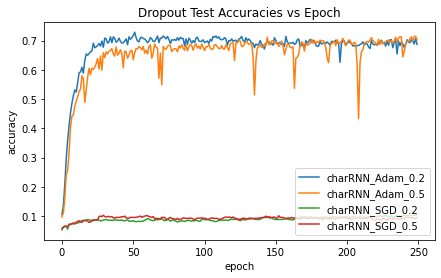

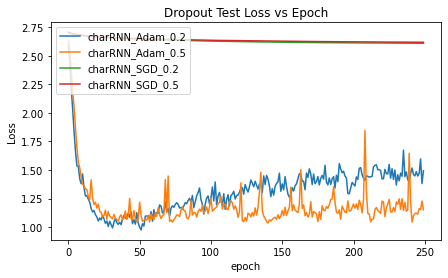

In [141]:
plt.figure(figsize=(7,4))
plt.plot(histories['charRNN_Adam_0.2']['test_acc'])
plt.plot(histories['charRNN_Adam_0.5']['test_acc'])
plt.plot(histories['charRNN_SGD_0.2']['test_acc'])
plt.plot(histories['charRNN_SGD_0.5']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['charRNN_Adam_0.2','charRNN_Adam_0.5','charRNN_SGD_0.2','charRNN_SGD_0.5'], loc='lower right')

plt.savefig(
    f'./results/partB_qn5_charRNN_dropout_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['charRNN_Adam_0.2']['test_loss'])
plt.plot(histories['charRNN_Adam_0.5']['test_loss'])
plt.plot(histories['charRNN_SGD_0.2']['test_loss'])
plt.plot(histories['charRNN_SGD_0.5']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['charRNN_Adam_0.2','charRNN_Adam_0.5','charRNN_SGD_0.2','charRNN_SGD_0.5'], loc='upper left')

plt.savefig(
    f'./results/partB_qn5_charRNN_dropout_loss.pdf'
)

In [142]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import nltk

nltk.download('punkt')

MAX_DOCUMENT_LENGTH = 100
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)


def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text


def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict


def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x


def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size


x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[nltk_data] Downloading package punkt to C:\Users\Shearman
[nltk_data]     Chua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [143]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.2)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_Adam_0.2'] = history

Epoch 1, Loss: 2.6711690425872803, Accuracy: 0.06857142597436905, Test Loss: 2.650054931640625, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.651442766189575, Accuracy: 0.07160714268684387, Test Loss: 2.646608591079712, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.648668050765991, Accuracy: 0.07392857223749161, Test Loss: 2.644428014755249, Test Accuracy: 0.06428571790456772
Epoch 4, Loss: 2.4449658393859863, Accuracy: 0.13124999403953552, Test Loss: 2.0102105140686035, Test Accuracy: 0.29571428894996643
Epoch 5, Loss: 1.6005241870880127, Accuracy: 0.386428564786911, Test Loss: 1.296523928642273, Test Accuracy: 0.5185714364051819
Epoch 6, Loss: 0.9992277026176453, Accuracy: 0.6194642782211304, Test Loss: 0.9613831043243408, Test Accuracy: 0.6728571653366089
Epoch 7, Loss: 0.6229422688484192, Accuracy: 0.8028571605682373, Test Loss: 0.7291579842567444, Test Accuracy: 0.8128571510314941
Epoch 8, Loss: 0.3803007900714874, Accuracy: 0.8974999785423279, Test Loss: 0.6540217995643

Epoch 64, Loss: 0.0035293661057949066, Accuracy: 0.9994642734527588, Test Loss: 0.8979290127754211, Test Accuracy: 0.8700000047683716
Epoch 65, Loss: 0.003974829334765673, Accuracy: 0.9992856979370117, Test Loss: 0.8986983299255371, Test Accuracy: 0.8728571534156799
Epoch 66, Loss: 0.0023537997622042894, Accuracy: 0.9998214244842529, Test Loss: 0.9189016819000244, Test Accuracy: 0.8714285492897034
Epoch 67, Loss: 0.0053487503901124, Accuracy: 0.9994642734527588, Test Loss: 0.9246008992195129, Test Accuracy: 0.8771428465843201
Epoch 68, Loss: 0.0026963783893734217, Accuracy: 0.9992856979370117, Test Loss: 0.950555145740509, Test Accuracy: 0.8771428465843201
Epoch 69, Loss: 0.0031172879971563816, Accuracy: 0.9992856979370117, Test Loss: 0.9588516354560852, Test Accuracy: 0.8771428465843201
Epoch 70, Loss: 0.0028405620250850916, Accuracy: 0.9998214244842529, Test Loss: 0.9800295233726501, Test Accuracy: 0.8785714507102966
Epoch 71, Loss: 0.003497984493151307, Accuracy: 0.9989285469055176,

Epoch 128, Loss: 0.0007308718049898744, Accuracy: 1.0, Test Loss: 0.9956428408622742, Test Accuracy: 0.895714282989502
Epoch 129, Loss: 0.0005222131730988622, Accuracy: 1.0, Test Loss: 1.0080584287643433, Test Accuracy: 0.8942857384681702
Epoch 130, Loss: 0.0007078811177052557, Accuracy: 1.0, Test Loss: 1.0095690488815308, Test Accuracy: 0.8942857384681702
Epoch 131, Loss: 0.0005327428225427866, Accuracy: 1.0, Test Loss: 1.0034948587417603, Test Accuracy: 0.8899999856948853
Epoch 132, Loss: 0.0006670432630926371, Accuracy: 0.9998214244842529, Test Loss: 1.0128960609436035, Test Accuracy: 0.8885714411735535
Epoch 133, Loss: 0.0005155503167770803, Accuracy: 1.0, Test Loss: 1.019673466682434, Test Accuracy: 0.8899999856948853
Epoch 134, Loss: 0.0004947633133269846, Accuracy: 1.0, Test Loss: 1.0166361331939697, Test Accuracy: 0.8899999856948853
Epoch 135, Loss: 0.00037678072112612426, Accuracy: 1.0, Test Loss: 1.0323060750961304, Test Accuracy: 0.8885714411735535
Epoch 136, Loss: 0.0002962

Epoch 193, Loss: 0.00034679711097851396, Accuracy: 1.0, Test Loss: 1.024384617805481, Test Accuracy: 0.8828571438789368
Epoch 194, Loss: 0.0003711830941028893, Accuracy: 1.0, Test Loss: 1.0047630071640015, Test Accuracy: 0.8842856884002686
Epoch 195, Loss: 0.0003427484480198473, Accuracy: 1.0, Test Loss: 1.0447331666946411, Test Accuracy: 0.881428599357605
Epoch 196, Loss: 0.0005379771464504302, Accuracy: 0.9998214244842529, Test Loss: 1.0396077632904053, Test Accuracy: 0.8771428465843201
Epoch 197, Loss: 0.0004375895659904927, Accuracy: 0.9998214244842529, Test Loss: 1.0344078540802002, Test Accuracy: 0.8785714507102966
Epoch 198, Loss: 0.00048608556971885264, Accuracy: 0.9998214244842529, Test Loss: 1.0386219024658203, Test Accuracy: 0.8828571438789368
Epoch 199, Loss: 0.0003099033492617309, Accuracy: 1.0, Test Loss: 1.0309520959854126, Test Accuracy: 0.8799999952316284
Epoch 200, Loss: 0.00040722035919316113, Accuracy: 0.9998214244842529, Test Loss: 1.0196082592010498, Test Accuracy

In [144]:
model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_Adam_0.5'] = history

Epoch 1, Loss: 2.681800603866577, Accuracy: 0.0726785734295845, Test Loss: 2.651855945587158, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.655693292617798, Accuracy: 0.07178571075201035, Test Loss: 2.647881269454956, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.652653455734253, Accuracy: 0.0746428593993187, Test Loss: 2.646906852722168, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.6524393558502197, Accuracy: 0.06589286029338837, Test Loss: 2.6439762115478516, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.6410601139068604, Accuracy: 0.07249999791383743, Test Loss: 2.5747878551483154, Test Accuracy: 0.11714285612106323
Epoch 6, Loss: 2.0648114681243896, Accuracy: 0.238571435213089, Test Loss: 1.5187922716140747, Test Accuracy: 0.44857141375541687
Epoch 7, Loss: 1.267827033996582, Accuracy: 0.5151785612106323, Test Loss: 0.9488286375999451, Test Accuracy: 0.618571400642395
Epoch 8, Loss: 0.824561357498169, Accuracy: 0.6919642686843872, Test Loss: 0.7714758515357971,

Epoch 64, Loss: 0.060311295092105865, Accuracy: 0.9782142639160156, Test Loss: 0.890035092830658, Test Accuracy: 0.8871428370475769
Epoch 65, Loss: 0.05354870855808258, Accuracy: 0.9803571701049805, Test Loss: 0.9004105925559998, Test Accuracy: 0.8842856884002686
Epoch 66, Loss: 0.03563190624117851, Accuracy: 0.9882143139839172, Test Loss: 0.9163475632667542, Test Accuracy: 0.8799999952316284
Epoch 67, Loss: 0.04469064995646477, Accuracy: 0.9826785922050476, Test Loss: 0.9344719052314758, Test Accuracy: 0.881428599357605
Epoch 68, Loss: 0.041628118604421616, Accuracy: 0.9833928346633911, Test Loss: 1.0069350004196167, Test Accuracy: 0.8714285492897034
Epoch 69, Loss: 0.043780162930488586, Accuracy: 0.9839285612106323, Test Loss: 0.9902052283287048, Test Accuracy: 0.8799999952316284
Epoch 70, Loss: 0.03557248413562775, Accuracy: 0.9857142567634583, Test Loss: 1.067851185798645, Test Accuracy: 0.8757143020629883
Epoch 71, Loss: 0.032664284110069275, Accuracy: 0.9873214364051819, Test Los

Epoch 126, Loss: 0.047813788056373596, Accuracy: 0.9837499856948853, Test Loss: 1.3335047960281372, Test Accuracy: 0.8571428656578064
Epoch 127, Loss: 0.048984989523887634, Accuracy: 0.9826785922050476, Test Loss: 1.5974777936935425, Test Accuracy: 0.8328571319580078
Epoch 128, Loss: 0.1796308010816574, Accuracy: 0.9585714340209961, Test Loss: 1.575735092163086, Test Accuracy: 0.8128571510314941
Epoch 129, Loss: 0.19391079246997833, Accuracy: 0.954285740852356, Test Loss: 1.2933188676834106, Test Accuracy: 0.845714271068573
Epoch 130, Loss: 0.12420062720775604, Accuracy: 0.9680356979370117, Test Loss: 1.210950493812561, Test Accuracy: 0.8471428751945496
Epoch 131, Loss: 0.09148332476615906, Accuracy: 0.9750000238418579, Test Loss: 1.0720919370651245, Test Accuracy: 0.8642857074737549
Epoch 132, Loss: 0.08519875258207321, Accuracy: 0.9769642949104309, Test Loss: 1.029342532157898, Test Accuracy: 0.8771428465843201
Epoch 133, Loss: 0.05849643796682358, Accuracy: 0.9819642901420593, Test 

Epoch 188, Loss: 0.0576162189245224, Accuracy: 0.9830357432365417, Test Loss: 1.2904937267303467, Test Accuracy: 0.8514285683631897
Epoch 189, Loss: 0.06181918457150459, Accuracy: 0.9816071391105652, Test Loss: 1.0985888242721558, Test Accuracy: 0.868571400642395
Epoch 190, Loss: 0.040940966457128525, Accuracy: 0.9842857122421265, Test Loss: 1.073419213294983, Test Accuracy: 0.8728571534156799
Epoch 191, Loss: 0.03783607855439186, Accuracy: 0.987500011920929, Test Loss: 1.0494589805603027, Test Accuracy: 0.8757143020629883
Epoch 192, Loss: 0.04914882034063339, Accuracy: 0.9869642853736877, Test Loss: 1.2197316884994507, Test Accuracy: 0.8657143115997314
Epoch 193, Loss: 0.04126812890172005, Accuracy: 0.9880357384681702, Test Loss: 1.0650330781936646, Test Accuracy: 0.8742856979370117
Epoch 194, Loss: 0.035421837121248245, Accuracy: 0.9891071319580078, Test Loss: 1.2242668867111206, Test Accuracy: 0.8642857074737549
Epoch 195, Loss: 0.03031114861369133, Accuracy: 0.989464282989502, Test

Epoch 250, Loss: 0.021237745881080627, Accuracy: 0.9905357360839844, Test Loss: 1.1620662212371826, Test Accuracy: 0.8785714507102966


In [145]:
model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.2)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_SGD_0.2'] = history

Epoch 1, Loss: 2.7088632583618164, Accuracy: 0.05267857015132904, Test Loss: 2.7053537368774414, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.70255970954895, Accuracy: 0.06785714626312256, Test Loss: 2.6998913288116455, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6976358890533447, Accuracy: 0.07553571462631226, Test Loss: 2.6953508853912354, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.6936521530151367, Accuracy: 0.07053571194410324, Test Loss: 2.691560983657837, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.6899075508117676, Accuracy: 0.06857142597436905, Test Loss: 2.6882846355438232, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.687544822692871, Accuracy: 0.06499999761581421, Test Loss: 2.6855227947235107, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.684964895248413, Accuracy: 0.07357142865657806, Test Loss: 2.6830742359161377, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.6829164028167725, Accuracy: 0.07107143104076385, Test Loss: 2.680930137

Epoch 64, Loss: 2.6565206050872803, Accuracy: 0.061964284628629684, Test Loss: 2.6500914096832275, Test Accuracy: 0.0714285746216774
Epoch 65, Loss: 2.6542181968688965, Accuracy: 0.0791071429848671, Test Loss: 2.649930000305176, Test Accuracy: 0.0714285746216774
Epoch 66, Loss: 2.655604124069214, Accuracy: 0.07392857223749161, Test Loss: 2.649829149246216, Test Accuracy: 0.0714285746216774
Epoch 67, Loss: 2.6549324989318848, Accuracy: 0.0694642886519432, Test Loss: 2.6496899127960205, Test Accuracy: 0.0714285746216774
Epoch 68, Loss: 2.653693914413452, Accuracy: 0.06857142597436905, Test Loss: 2.649524450302124, Test Accuracy: 0.0714285746216774
Epoch 69, Loss: 2.654996633529663, Accuracy: 0.06910714507102966, Test Loss: 2.6494076251983643, Test Accuracy: 0.0714285746216774
Epoch 70, Loss: 2.6542723178863525, Accuracy: 0.06892856955528259, Test Loss: 2.649301290512085, Test Accuracy: 0.0714285746216774
Epoch 71, Loss: 2.65458083152771, Accuracy: 0.0682142823934555, Test Loss: 2.6491963

Epoch 127, Loss: 2.652534246444702, Accuracy: 0.06982143223285675, Test Loss: 2.645766019821167, Test Accuracy: 0.0714285746216774
Epoch 128, Loss: 2.651228666305542, Accuracy: 0.06499999761581421, Test Loss: 2.6457526683807373, Test Accuracy: 0.0714285746216774
Epoch 129, Loss: 2.6490225791931152, Accuracy: 0.07392857223749161, Test Loss: 2.6456832885742188, Test Accuracy: 0.0714285746216774
Epoch 130, Loss: 2.6503849029541016, Accuracy: 0.07392857223749161, Test Loss: 2.64565110206604, Test Accuracy: 0.0714285746216774
Epoch 131, Loss: 2.6495261192321777, Accuracy: 0.07374999672174454, Test Loss: 2.645595073699951, Test Accuracy: 0.0714285746216774
Epoch 132, Loss: 2.649791955947876, Accuracy: 0.06767857074737549, Test Loss: 2.6455495357513428, Test Accuracy: 0.0714285746216774
Epoch 133, Loss: 2.6483161449432373, Accuracy: 0.07178571075201035, Test Loss: 2.6455020904541016, Test Accuracy: 0.0714285746216774
Epoch 134, Loss: 2.6506242752075195, Accuracy: 0.06875000149011612, Test Los

Epoch 190, Loss: 2.6466023921966553, Accuracy: 0.07625000178813934, Test Loss: 2.644155740737915, Test Accuracy: 0.0714285746216774
Epoch 191, Loss: 2.648580551147461, Accuracy: 0.0694642886519432, Test Loss: 2.644138813018799, Test Accuracy: 0.0714285746216774
Epoch 192, Loss: 2.6486668586730957, Accuracy: 0.06857142597436905, Test Loss: 2.644120216369629, Test Accuracy: 0.0714285746216774
Epoch 193, Loss: 2.648627519607544, Accuracy: 0.0694642886519432, Test Loss: 2.644127607345581, Test Accuracy: 0.0714285746216774
Epoch 194, Loss: 2.646975517272949, Accuracy: 0.07214285433292389, Test Loss: 2.6440937519073486, Test Accuracy: 0.0714285746216774
Epoch 195, Loss: 2.645752429962158, Accuracy: 0.07303571701049805, Test Loss: 2.6440622806549072, Test Accuracy: 0.0714285746216774
Epoch 196, Loss: 2.647688865661621, Accuracy: 0.0726785734295845, Test Loss: 2.644049882888794, Test Accuracy: 0.0714285746216774
Epoch 197, Loss: 2.6497137546539307, Accuracy: 0.06410714238882065, Test Loss: 2.6

In [146]:
model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_SGD_0.5'] = history

Epoch 1, Loss: 2.7045273780822754, Accuracy: 0.0694642886519432, Test Loss: 2.7013895511627197, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.7004706859588623, Accuracy: 0.07482142746448517, Test Loss: 2.6974360942840576, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.69582462310791, Accuracy: 0.06964285671710968, Test Loss: 2.6938693523406982, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.693817138671875, Accuracy: 0.07071428745985031, Test Loss: 2.6911256313323975, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.6910860538482666, Accuracy: 0.07303571701049805, Test Loss: 2.6885995864868164, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.6877102851867676, Accuracy: 0.07053571194410324, Test Loss: 2.6861660480499268, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.6879947185516357, Accuracy: 0.06714285910129547, Test Loss: 2.6842763423919678, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.6854820251464844, Accuracy: 0.0701785683631897, Test Loss: 2.682468652

Epoch 64, Loss: 2.661003351211548, Accuracy: 0.07696428894996643, Test Loss: 2.6565968990325928, Test Accuracy: 0.0714285746216774
Epoch 65, Loss: 2.662898063659668, Accuracy: 0.0637499988079071, Test Loss: 2.6564953327178955, Test Accuracy: 0.0714285746216774
Epoch 66, Loss: 2.662858724594116, Accuracy: 0.06767857074737549, Test Loss: 2.656407117843628, Test Accuracy: 0.0714285746216774
Epoch 67, Loss: 2.658602237701416, Accuracy: 0.0746428593993187, Test Loss: 2.6560792922973633, Test Accuracy: 0.0714285746216774
Epoch 68, Loss: 2.659926652908325, Accuracy: 0.07089285552501678, Test Loss: 2.655863046646118, Test Accuracy: 0.0714285746216774
Epoch 69, Loss: 2.661870002746582, Accuracy: 0.0694642886519432, Test Loss: 2.6558241844177246, Test Accuracy: 0.0714285746216774
Epoch 70, Loss: 2.660386800765991, Accuracy: 0.07392857223749161, Test Loss: 2.65570330619812, Test Accuracy: 0.0714285746216774
Epoch 71, Loss: 2.6598634719848633, Accuracy: 0.07642856985330582, Test Loss: 2.6555438041

Epoch 127, Loss: 2.653730630874634, Accuracy: 0.07196428626775742, Test Loss: 2.650864839553833, Test Accuracy: 0.0714285746216774
Epoch 128, Loss: 2.6542587280273438, Accuracy: 0.07214285433292389, Test Loss: 2.650808095932007, Test Accuracy: 0.0714285746216774
Epoch 129, Loss: 2.6543431282043457, Accuracy: 0.06875000149011612, Test Loss: 2.6507365703582764, Test Accuracy: 0.0714285746216774
Epoch 130, Loss: 2.6523959636688232, Accuracy: 0.07571428269147873, Test Loss: 2.6505627632141113, Test Accuracy: 0.0714285746216774
Epoch 131, Loss: 2.6542892456054688, Accuracy: 0.06428571790456772, Test Loss: 2.650550365447998, Test Accuracy: 0.0714285746216774
Epoch 132, Loss: 2.653352975845337, Accuracy: 0.07357142865657806, Test Loss: 2.6504647731781006, Test Accuracy: 0.0714285746216774
Epoch 133, Loss: 2.6522738933563232, Accuracy: 0.07999999821186066, Test Loss: 2.6502463817596436, Test Accuracy: 0.0714285746216774
Epoch 134, Loss: 2.654050588607788, Accuracy: 0.06624999642372131, Test Lo

Epoch 189, Loss: 2.6517250537872314, Accuracy: 0.0701785683631897, Test Loss: 2.648010730743408, Test Accuracy: 0.0714285746216774
Epoch 190, Loss: 2.6528780460357666, Accuracy: 0.06589286029338837, Test Loss: 2.6481025218963623, Test Accuracy: 0.0714285746216774
Epoch 191, Loss: 2.6507980823516846, Accuracy: 0.0669642835855484, Test Loss: 2.6480987071990967, Test Accuracy: 0.0714285746216774
Epoch 192, Loss: 2.648606300354004, Accuracy: 0.07535714656114578, Test Loss: 2.6479384899139404, Test Accuracy: 0.0714285746216774
Epoch 193, Loss: 2.650057315826416, Accuracy: 0.07339286059141159, Test Loss: 2.647878646850586, Test Accuracy: 0.0714285746216774
Epoch 194, Loss: 2.6498615741729736, Accuracy: 0.06928571313619614, Test Loss: 2.6478030681610107, Test Accuracy: 0.0714285746216774
Epoch 195, Loss: 2.651043176651001, Accuracy: 0.07410714030265808, Test Loss: 2.6478188037872314, Test Accuracy: 0.0714285746216774
Epoch 196, Loss: 2.6500253677368164, Accuracy: 0.06928571313619614, Test Los

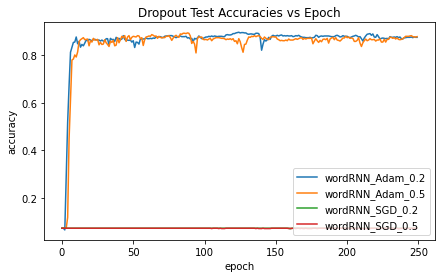

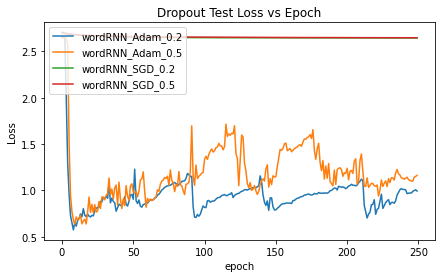

In [147]:
plt.figure(figsize=(7,4))
plt.plot(histories['wordRNN_Adam_0.2']['test_acc'])
plt.plot(histories['wordRNN_Adam_0.5']['test_acc'])
plt.plot(histories['wordRNN_SGD_0.2']['test_acc'])
plt.plot(histories['wordRNN_SGD_0.5']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['wordRNN_Adam_0.2','wordRNN_Adam_0.5','wordRNN_SGD_0.2','wordRNN_SGD_0.5'], loc='lower right')

plt.savefig(
    f'./results/partB_qn5_wordRNN_dropout_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['wordRNN_Adam_0.2']['test_loss'])
plt.plot(histories['wordRNN_Adam_0.5']['test_loss'])
plt.plot(histories['wordRNN_SGD_0.2']['test_loss'])
plt.plot(histories['wordRNN_SGD_0.5']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['wordRNN_Adam_0.2','wordRNN_Adam_0.5','wordRNN_SGD_0.2','wordRNN_SGD_0.5'], loc='upper left')

plt.savefig(
    f'./results/partB_qn5_wordRNN_dropout_loss.pdf'
)